
# Global Disaster Response: Predictive Modeling & Machine Learning

---
# 📘 **Note:**  
 This notebook is a continuation of **Part 1**, so make sure to check that out first — it contains the detailed EDA that this analysis builds upon.  
  
 🔗 [**Part 1: Simpson’s Paradox — Deep EDA on Global Disasters**](https://www.kaggle.com/code/seki32/simpson-s-paradox-deep-eda-global-disaster)  

 I’ve put a lot of effort into creating these notebooks, so if you find them helpful or insightful, please consider **upvoting** ❤️ — it really helps keep me motivated to share more quality work with the community!

## About This Notebook
## First This is the all thing's you can do with this data-set
This is **Part 2** of our comprehensive disaster response analysis. Building on insights from
our EDA notebook (Simpson's Paradox & 25+ Advanced Visualizations), we now develop predictive
models to forecast disaster outcomes and optimize response strategies.

### If you find this analysis valuable, please consider giving an upvote. Your support motivates me to create more high-quality content for the community.

---

## Notebook Objectives

We will build models to predict:

1. **Recovery Days** - How long will it take to recover from a disaster?
2. **Response Efficiency Score** - How efficient will the response be?
3. **Casualty Severity Classification** - Low, Medium, or High casualty events?
4. **Economic Loss Prediction** - What will be the financial impact?

---

## Key Insights from EDA That Inform Our Modeling

From our exploratory analysis, we discovered:

| Finding | Modeling Implication |
|---------|---------------------|
| Simpson's Paradox in Response Time vs Casualties | Must include disaster_type as interaction term |
| Seasonal patterns vary by disaster type | Month/Season features are important |
| Country clusters exist with similar risk profiles | Country encoding matters significantly |
| Strong correlation: Severity → Recovery Days | Severity is a key predictor |
| Anomalies exist (2% of data) | Consider robust models or outlier handling |
| Co-occurrence patterns | Feature engineering for compound disasters |

---

## Modeling Approach

1. **Baseline Models**: Simple models to establish benchmarks
2. **Feature Engineering**: Create powerful predictive features from EDA insights
3. **Model Selection**: Compare multiple algorithms
4. **Hyperparameter Tuning**: Optimize best performers
5. **Ensemble Methods**: Combine models for best results
6. **Interpretation**: SHAP values and feature importance

---

## Models We Will Build

| Target Variable | Problem Type | Algorithms |
|-----------------|--------------|------------|
| Recovery Days | Regression | Linear, Ridge, Random Forest, XGBoost, LightGBM |
| Response Efficiency | Regression | Same as above |
| Casualty Level | Classification | Logistic, Random Forest, XGBoost, LightGBM |
| Economic Loss | Regression | Same regression models |

---

Let's build some powerful models!


## Imports and Configuration

In [5]:
!pip install protobuf==3.20.3

# Core Libraries
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model Selection & Validation
from sklearn.model_selection import (train_test_split, cross_val_score, KFold,
                                      StratifiedKFold, GridSearchCV, RandomizedSearchCV,
                                      learning_curve, validation_curve)

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                               AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor,
                               StackingRegressor, BaggingRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier,
                               StackingClassifier, BaggingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                              accuracy_score, precision_score, recall_score, f1_score,
                              classification_report, confusion_matrix, roc_auc_score,
                              roc_curve, precision_recall_curve, mean_absolute_percentage_error)

# Advanced Models
try:
    import xgboost as xgb
    from xgboost import XGBRegressor, XGBClassifier
    XGB_AVAILABLE = True
    print("XGBoost loaded successfully")
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not available - installing...")
    !pip install xgboost -q
    import xgboost as xgb
    from xgboost import XGBRegressor, XGBClassifier
    XGB_AVAILABLE = True

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor, LGBMClassifier
    LGBM_AVAILABLE = True
    print("LightGBM loaded successfully")
except ImportError:
    LGBM_AVAILABLE = False
    print("LightGBM not available - installing...")
    !pip install lightgbm -q
    import lightgbm as lgb
    from lightgbm import LGBMRegressor, LGBMClassifier
    LGBM_AVAILABLE = True

try:
    !pip install catboost
    import catboost
    from catboost import CatBoostRegressor, CatBoostClassifier
    CATBOOST_AVAILABLE = True
    print("CatBoost loaded successfully")
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available - will skip")

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 120
})

# Color palette
COLORS = {
    'primary': '#264653',
    'secondary': '#2A9D8F',
    'accent': '#E9C46A',
    'warning': '#F4A261',
    'danger': '#E76F51'
}

print("\n" + "=" * 50)
print("All libraries loaded successfully!")
print("=" * 50)

XGBoost loaded successfully
LightGBM loaded successfully
CatBoost loaded successfully

All libraries loaded successfully!


## Data Loading and Initial Processing

In [6]:
# Download latest version
path = kagglehub.dataset_download("zubairdhuddi/global-daset")

print("Path to dataset files:", path)

# Load the dataset
df = pd.read_csv(os.path.join(path,'global_disaster_response_2018_2024 (1).csv'))

100%|██████████| 1.66M/1.66M [00:00<00:00, 2.91MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zubairdhuddi/global-daset/versions/1


In [9]:
df.head()

,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137


In [10]:
df.shape

(50000, 12)

In [11]:
df.isna().sum()

,0
date,0
country,0
disaster_type,0
severity_index,0
casualties,0
economic_loss_usd,0
response_time_hours,0
aid_amount_usd,0
response_efficiency_score,0
recovery_days,0


In [12]:
df.duplicated().sum()

np.int64(0)

In [7]:
# Convert date
df['date'] = pd.to_datetime(df['date'])

## Feature Engineering

In [13]:
# Create a copy for modeling
data = df.copy()

# =============================================================================
# TEMPORAL FEATURES
# =============================================================================
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_year'] = data['date'].dt.dayofyear
data['week_of_year'] = data['date'].dt.isocalendar().week.astype(int)
data['quarter'] = data['date'].dt.quarter
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Season (Northern Hemisphere)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['season'] = data['month'].apply(get_season)

# =============================================================================
# GEOGRAPHIC FEATURES
# =============================================================================
continent_map = {
    'Brazil': 'South America', 'Chile': 'South America',
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'France': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe', 'Spain': 'Europe',
    'Italy': 'Europe', 'Turkey': 'Europe',
    'India': 'Asia', 'Indonesia': 'Asia', 'Philippines': 'Asia', 'Japan': 'Asia',
    'China': 'Asia', 'Bangladesh': 'Asia',
    'South Africa': 'Africa', 'Nigeria': 'Africa',
    'Australia': 'Oceania'
}
data['continent'] = data['country'].map(continent_map)

# Hemisphere based on latitude
data['hemisphere'] = np.where(data['latitude'] >= 0, 'Northern', 'Southern')

# Distance from equator (absolute latitude)
data['dist_from_equator'] = np.abs(data['latitude'])

# Coastal indicator (rough proxy - within certain longitude ranges)
data['is_coastal'] = ((np.abs(data['longitude']) > 100) | (np.abs(data['longitude']) < 30)).astype(int)

# =============================================================================
# SEVERITY-BASED FEATURES
# =============================================================================
# Severity categories
data['severity_category'] = pd.cut(data['severity_index'],
                                    bins=[0, 3, 5, 7, 10],
                                    labels=['Low', 'Medium', 'High', 'Extreme'])

# Log transformations for skewed features
data['log_casualties'] = np.log1p(data['casualties'])
data['log_economic_loss'] = np.log1p(data['economic_loss_usd'])
data['log_aid_amount'] = np.log1p(data['aid_amount_usd'])

# =============================================================================
# RATIO FEATURES (From EDA insights)
# =============================================================================
data['aid_per_casualty'] = data['aid_amount_usd'] / (data['casualties'] + 1)
data['loss_per_severity'] = data['economic_loss_usd'] / (data['severity_index'] + 0.1)
data['aid_to_loss_ratio'] = data['aid_amount_usd'] / (data['economic_loss_usd'] + 1)
data['casualties_per_severity'] = data['casualties'] / (data['severity_index'] + 0.1)
data['efficiency_per_hour'] = data['response_efficiency_score'] / (data['response_time_hours'] + 0.1)

# =============================================================================
# INTERACTION FEATURES (Based on Simpson's Paradox findings)
# =============================================================================
# Disaster type severity interaction
disaster_severity_map = data.groupby('disaster_type')['severity_index'].mean().to_dict()
data['disaster_avg_severity'] = data['disaster_type'].map(disaster_severity_map)
data['severity_vs_disaster_avg'] = data['severity_index'] - data['disaster_avg_severity']

# Country efficiency interaction
country_efficiency_map = data.groupby('country')['response_efficiency_score'].mean().to_dict()
data['country_avg_efficiency'] = data['country'].map(country_efficiency_map)
data['efficiency_vs_country_avg'] = data['response_efficiency_score'] - data['country_avg_efficiency']

# =============================================================================
# HISTORICAL/AGGREGATE FEATURES (Country-level statistics)
# =============================================================================
country_stats = data.groupby('country').agg({
    'casualties': ['mean', 'std', 'sum'],
    'economic_loss_usd': ['mean', 'sum'],
    'severity_index': ['mean', 'max'],
    'response_time_hours': 'mean',
    'recovery_days': 'mean'
}).reset_index()
country_stats.columns = ['country'] + ['_'.join(col).strip('_') for col in country_stats.columns[1:]]

# Merge back
data = data.merge(country_stats, on='country', suffixes=('', '_country'))

# =============================================================================
# DISASTER TYPE STATISTICS
# =============================================================================
disaster_stats = data.groupby('disaster_type').agg({
    'casualties': 'mean',
    'recovery_days': 'mean',
    'response_time_hours': 'mean'
}).reset_index()
disaster_stats.columns = ['disaster_type', 'disaster_avg_casualties',
                           'disaster_avg_recovery', 'disaster_avg_response_time']

data = data.merge(disaster_stats, on='disaster_type')

# =============================================================================
# TARGET VARIABLE FOR CLASSIFICATION
# =============================================================================
# Casualty severity classification
data['casualty_level'] = pd.cut(data['casualties'],
                                 bins=[0, 50, 150, float('inf')],
                                 labels=['Low', 'Medium', 'High'])

print("=" * 70)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 70)
print(f"\nOriginal features: {df.shape[1]}")
print(f"Engineered features: {data.shape[1]}")
print(f"New features created: {data.shape[1] - df.shape[1]}")

# Display new features
new_cols = [col for col in data.columns if col not in df.columns]
print(f"\nNew Features ({len(new_cols)}):")
for i, col in enumerate(new_cols, 1):
    print(f"  {i:2d}. {col}")

FEATURE ENGINEERING COMPLETE

Original features: 12
Engineered features: 51
New features created: 39

New Features (39):
   1. year
   2. month
   3. day
   4. day_of_week
   5. day_of_year
   6. week_of_year
   7. quarter
   8. is_weekend
   9. season
  10. continent
  11. hemisphere
  12. dist_from_equator
  13. is_coastal
  14. severity_category
  15. log_casualties
  16. log_economic_loss
  17. log_aid_amount
  18. aid_per_casualty
  19. loss_per_severity
  20. aid_to_loss_ratio
  21. casualties_per_severity
  22. efficiency_per_hour
  23. disaster_avg_severity
  24. severity_vs_disaster_avg
  25. country_avg_efficiency
  26. efficiency_vs_country_avg
  27. casualties_mean
  28. casualties_std
  29. casualties_sum
  30. economic_loss_usd_mean
  31. economic_loss_usd_sum
  32. severity_index_mean
  33. severity_index_max
  34. response_time_hours_mean
  35. recovery_days_mean
  36. disaster_avg_casualties
  37. disaster_avg_recovery
  38. disaster_avg_response_time
  39. casualty_le

## Feature Engineering Visualization

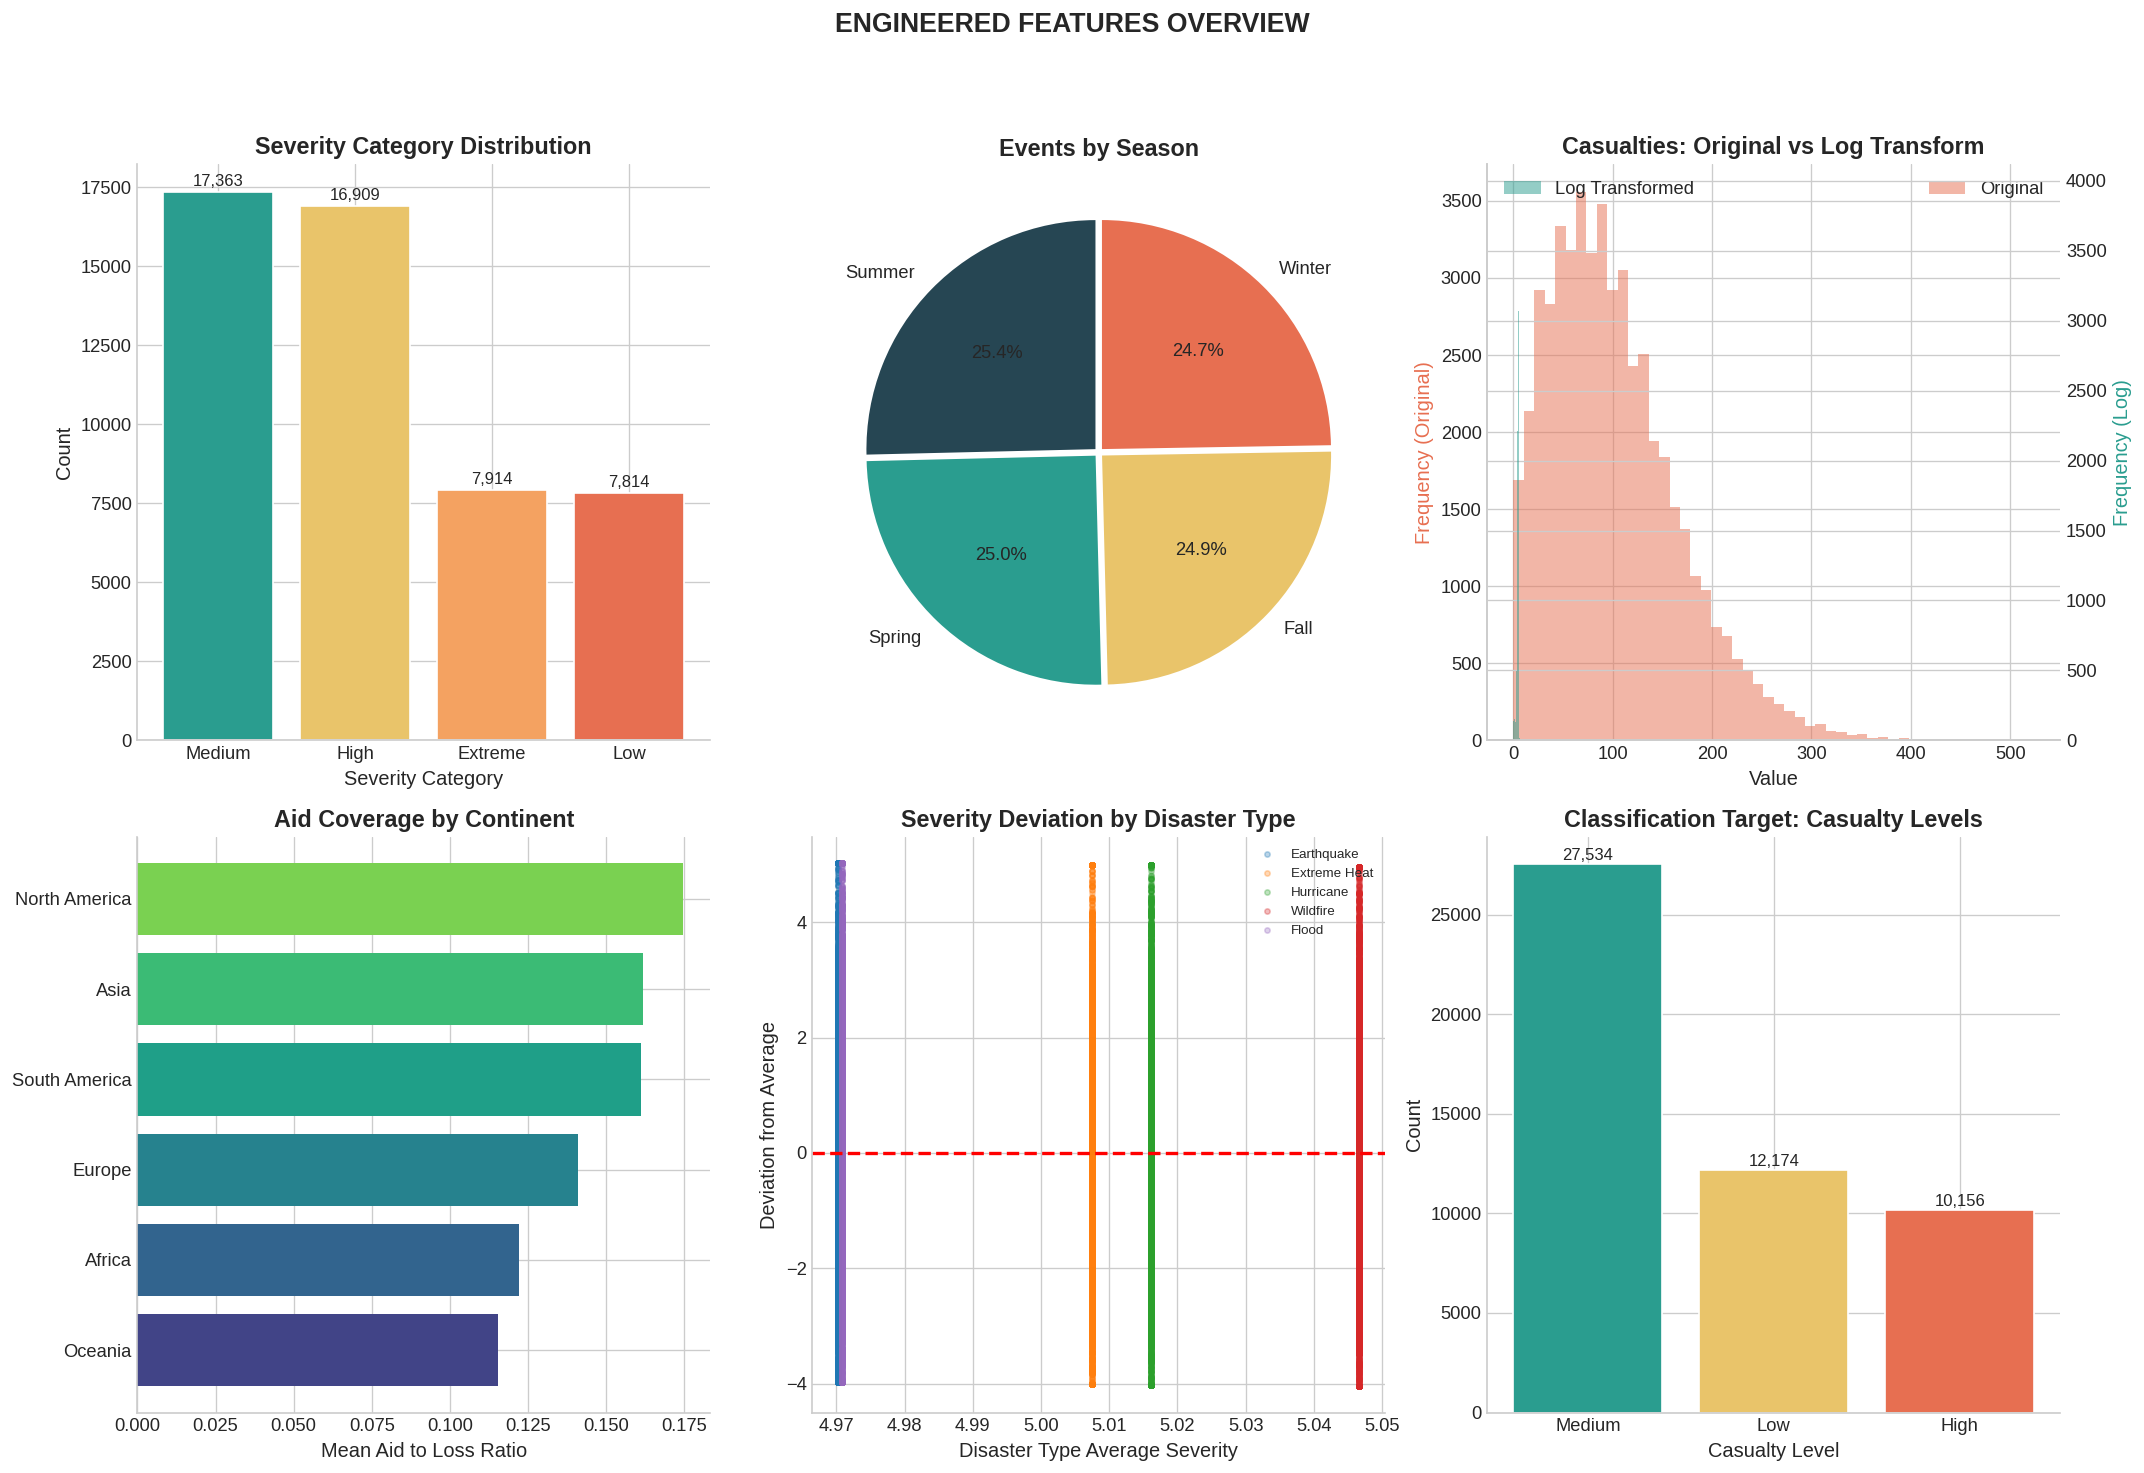


Feature engineering adds domain knowledge to raw data,
transforming patterns discovered in EDA into predictive power.


In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Panel 1: Severity categories distribution
ax1 = axes[0, 0]
severity_counts = data['severity_category'].value_counts()
colors = ['#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
ax1.bar(severity_counts.index, severity_counts.values, color=colors, edgecolor='white')
ax1.set_xlabel('Severity Category')
ax1.set_ylabel('Count')
ax1.set_title('Severity Category Distribution', fontweight='bold')
for i, v in enumerate(severity_counts.values):
    ax1.text(i, v + 200, f'{v:,}', ha='center', fontsize=10)

# Panel 2: Season distribution
ax2 = axes[0, 1]
season_counts = data['season'].value_counts()
colors_season = ['#264653', '#2A9D8F', '#E9C46A', '#E76F51']
ax2.pie(season_counts.values, labels=season_counts.index, colors=colors_season,
        autopct='%1.1f%%', startangle=90, explode=[0.02]*4)
ax2.set_title('Events by Season', fontweight='bold')

# Panel 3: Log transformations comparison
ax3 = axes[0, 2]
ax3.hist(data['casualties'], bins=50, alpha=0.5, label='Original', color='#E76F51')
ax3_twin = ax3.twinx()
ax3_twin.hist(data['log_casualties'], bins=50, alpha=0.5, label='Log Transformed', color='#2A9D8F')
ax3.set_xlabel('Value')
ax3.set_ylabel('Frequency (Original)', color='#E76F51')
ax3_twin.set_ylabel('Frequency (Log)', color='#2A9D8F')
ax3.set_title('Casualties: Original vs Log Transform', fontweight='bold')
ax3.legend(loc='upper right')
ax3_twin.legend(loc='upper left')

# Panel 4: Aid to Loss Ratio by Continent
ax4 = axes[1, 0]
continent_ratio = data.groupby('continent')['aid_to_loss_ratio'].mean().sort_values(ascending=True)
colors_cont = plt.cm.viridis(np.linspace(0.2, 0.8, len(continent_ratio)))
ax4.barh(continent_ratio.index, continent_ratio.values, color=colors_cont)
ax4.set_xlabel('Mean Aid to Loss Ratio')
ax4.set_title('Aid Coverage by Continent', fontweight='bold')

# Panel 5: Severity vs Disaster Average
ax5 = axes[1, 1]
for disaster in data['disaster_type'].unique()[:5]:  # Top 5 for clarity
    subset = data[data['disaster_type'] == disaster]
    ax5.scatter(subset['disaster_avg_severity'], subset['severity_vs_disaster_avg'],
               alpha=0.3, s=10, label=disaster)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Disaster Type Average Severity')
ax5.set_ylabel('Deviation from Average')
ax5.set_title('Severity Deviation by Disaster Type', fontweight='bold')
ax5.legend(fontsize=8)

# Panel 6: Casualty Level Distribution
ax6 = axes[1, 2]
casualty_level_counts = data['casualty_level'].value_counts()
colors_cas = ['#2A9D8F', '#E9C46A', '#E76F51']
bars = ax6.bar(casualty_level_counts.index, casualty_level_counts.values,
               color=colors_cas, edgecolor='white')
ax6.set_xlabel('Casualty Level')
ax6.set_ylabel('Count')
ax6.set_title('Classification Target: Casualty Levels', fontweight='bold')
for bar, v in zip(bars, casualty_level_counts.values):
    ax6.text(bar.get_x() + bar.get_width()/2, v + 200, f'{v:,}', ha='center', fontsize=10)

plt.suptitle('ENGINEERED FEATURES OVERVIEW\n', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nFeature engineering adds domain knowledge to raw data,")
print("transforming patterns discovered in EDA into predictive power.")

## Prepare Data for Modeling

In [15]:
"""
We prepare separate datasets for our different prediction tasks:
1. Recovery Days Prediction (Regression)
2. Response Efficiency Prediction (Regression)
3. Casualty Level Classification (Classification)
4. Economic Loss Prediction (Regression)
"""

# Define feature sets
# Categorical features to encode
categorical_features = ['country', 'disaster_type', 'continent', 'season',
                        'hemisphere', 'severity_category']

# Numerical features
numerical_features = ['severity_index', 'casualties', 'economic_loss_usd',
                      'response_time_hours', 'aid_amount_usd', 'latitude', 'longitude',
                      'year', 'month', 'day_of_week', 'quarter', 'is_weekend',
                      'dist_from_equator', 'is_coastal', 'log_casualties',
                      'log_economic_loss', 'log_aid_amount', 'aid_per_casualty',
                      'loss_per_severity', 'aid_to_loss_ratio', 'casualties_per_severity',
                      'efficiency_per_hour', 'disaster_avg_severity', 'severity_vs_disaster_avg',
                      'country_avg_efficiency', 'casualties_mean', 'casualties_std',
                      'economic_loss_usd_mean', 'severity_index_mean', 'severity_index_max',
                      'response_time_hours_mean', 'recovery_days_mean',
                      'disaster_avg_casualties', 'disaster_avg_recovery', 'disaster_avg_response_time']

# Remove target-related features when predicting specific targets
# For Recovery Days prediction - remove efficiency as it may leak info
features_for_recovery = [f for f in numerical_features if 'efficiency' not in f.lower()
                         and 'recovery' not in f.lower()]

# For Efficiency prediction
features_for_efficiency = [f for f in numerical_features if 'efficiency' not in f.lower()]

# For Casualty prediction - remove casualty-related features
features_for_casualty = [f for f in numerical_features if 'casualt' not in f.lower()]

# For Economic Loss prediction
features_for_loss = [f for f in numerical_features if 'loss' not in f.lower()
                     and 'economic' not in f.lower()]

# =============================================================================
# ENCODE CATEGORICAL FEATURES
# =============================================================================
# Label encoding for tree-based models
label_encoders = {}
data_encoded = data.copy()

for col in categorical_features:
    le = LabelEncoder()
    data_encoded[col + '_encoded'] = le.fit_transform(data_encoded[col].astype(str))
    label_encoders[col] = le

# Add encoded features to numerical list
encoded_features = [col + '_encoded' for col in categorical_features]

print("=" * 70)
print("DATA PREPARATION SUMMARY")
print("=" * 70)
print(f"\nCategorical Features: {len(categorical_features)}")
print(f"Numerical Features: {len(numerical_features)}")
print(f"Encoded Features: {len(encoded_features)}")

print("\n" + "-" * 70)
print("FEATURE SETS BY TARGET")
print("-" * 70)
print(f"Recovery Days: {len(features_for_recovery)} features")
print(f"Efficiency: {len(features_for_efficiency)} features")
print(f"Casualty Level: {len(features_for_casualty)} features")
print(f"Economic Loss: {len(features_for_loss)} features")

# Display target distributions
print("\n" + "-" * 70)
print("TARGET VARIABLE STATISTICS")
print("-" * 70)

targets = {
    'Recovery Days': 'recovery_days',
    'Response Efficiency': 'response_efficiency_score',
    'Casualty Level': 'casualty_level',
    'Economic Loss': 'economic_loss_usd'
}

for name, col in targets.items():
    if data[col].dtype == 'object' or str(data[col].dtype) == 'category':
        print(f"\n{name} (Classification):")
        print(data[col].value_counts())
    else:
        print(f"\n{name} (Regression):")
        print(f"  Mean: {data[col].mean():,.2f}")
        print(f"  Std:  {data[col].std():,.2f}")
        print(f"  Min:  {data[col].min():,.2f}")
        print(f"  Max:  {data[col].max():,.2f}")

DATA PREPARATION SUMMARY

Categorical Features: 6
Numerical Features: 35
Encoded Features: 6

----------------------------------------------------------------------
FEATURE SETS BY TARGET
----------------------------------------------------------------------
Recovery Days: 31 features
Efficiency: 33 features
Casualty Level: 28 features
Economic Loss: 30 features

----------------------------------------------------------------------
TARGET VARIABLE STATISTICS
----------------------------------------------------------------------

Recovery Days (Regression):
  Mean: 49.68
  Std:  20.10
  Min:  2.00
  Max:  112.00

Response Efficiency (Regression):
  Mean: 87.57
  Std:  10.19
  Min:  29.75
  Max:  100.00

Casualty Level (Classification):
casualty_level
Medium    27534
Low       12174
High      10156
Name: count, dtype: int64

Economic Loss (Regression):
  Mean: 5,068,593.45
  Std:  3,268,540.52
  Min:  527.39
  Max:  24,456,237.87


## Train-Test Split

In [16]:
data.head()

,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,...,economic_loss_usd_mean,economic_loss_usd_sum,severity_index_mean,severity_index_max,response_time_hours_mean,recovery_days_mean,disaster_avg_casualties,disaster_avg_recovery,disaster_avg_response_time,casualty_level
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,...,5.096822e+06,1.320587e+10,5.049487,10.0,11.986469,49.805095,100.005722,49.218824,12.340716,Medium
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,...,5.096822e+06,1.320587e+10,5.049487,10.0,11.986469,49.805095,99.530294,49.616477,12.375869,Medium
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,...,5.044030e+06,1.265547e+10,4.992981,10.0,12.191993,49.458749,100.270892,49.754898,12.041757,Low
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,...,5.113786e+06,1.261571e+10,5.085938,10.0,12.033887,50.452777,99.530294,49.616477,12.375869,Medium
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,...,5.122040e+06,1.235948e+10,5.022279,10.0,12.444190,49.703274,101.220024,50.027453,12.093817,Medium


In [17]:
# Set random state for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2

# TASK 1: RECOVERY DAYS PREDICTION
feature_cols_recovery = features_for_recovery + encoded_features
X_recovery = data_encoded[feature_cols_recovery].copy()
y_recovery = data_encoded['recovery_days'].copy()

# Handle any infinities
X_recovery = X_recovery.replace([np.inf, -np.inf], np.nan)
X_recovery = X_recovery.fillna(X_recovery.median())

X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(
    X_recovery, y_recovery, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


# TASK 2: EFFICIENCY PREDICTION
feature_cols_eff = features_for_efficiency + encoded_features
X_efficiency = data_encoded[feature_cols_eff].copy()
y_efficiency = data_encoded['response_efficiency_score'].copy()

X_efficiency = X_efficiency.replace([np.inf, -np.inf], np.nan)
X_efficiency = X_efficiency.fillna(X_efficiency.median())

X_train_eff, X_test_eff, y_train_eff, y_test_eff = train_test_split(
    X_efficiency, y_efficiency, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


# TASK 3: CASUALTY LEVEL CLASSIFICATION
feature_cols_cas = features_for_casualty + encoded_features
X_casualty = data_encoded[feature_cols_cas].copy()
y_casualty = data_encoded['casualty_level'].copy()

# Encode target
le_casualty = LabelEncoder()
y_casualty_encoded = le_casualty.fit_transform(y_casualty)

X_casualty = X_casualty.replace([np.inf, -np.inf], np.nan)
X_casualty = X_casualty.fillna(X_casualty.median())

X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(
    X_casualty, y_casualty_encoded, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=y_casualty_encoded
)

# TASK 4: ECONOMIC LOSS PREDICTION
feature_cols_loss = features_for_loss + encoded_features
X_loss = data_encoded[feature_cols_loss].copy()
y_loss = data_encoded['economic_loss_usd'].copy()
y_loss_log = np.log1p(y_loss)  # Log transform for better prediction

X_loss = X_loss.replace([np.inf, -np.inf], np.nan)
X_loss = X_loss.fillna(X_loss.median())

X_train_loss, X_test_loss, y_train_loss, y_test_loss = train_test_split(
    X_loss, y_loss_log, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("=" * 70)
print("TRAIN-TEST SPLIT SUMMARY")
print("=" * 70)

splits = [
    ("Recovery Days", X_train_rec, X_test_rec),
    ("Efficiency", X_train_eff, X_test_eff),
    ("Casualty Level", X_train_cas, X_test_cas),
    ("Economic Loss", X_train_loss, X_test_loss)
]

print(f"\n{'Task':<20} {'Train Size':<15} {'Test Size':<15} {'Features':<10}")
print("-" * 60)
for name, X_tr, X_te in splits:
    print(f"{name:<20} {X_tr.shape[0]:<15,} {X_te.shape[0]:<15,} {X_tr.shape[1]:<10}")

print(f"\nTest Size: {TEST_SIZE*100:.0f}%")
print(f"Random State: {RANDOM_STATE}")

TRAIN-TEST SPLIT SUMMARY

Task                 Train Size      Test Size       Features  
------------------------------------------------------------
Recovery Days        40,000          10,000          37        
Efficiency           40,000          10,000          39        
Casualty Level       40,000          10,000          34        
Economic Loss        40,000          10,000          36        

Test Size: 20%
Random State: 42


## Baseline Models - Recovery Days Prediction

RECOVERY DAYS PREDICTION - BASELINE MODELS

Model                     RMSE         MAE          R² Score    
-----------------------------------------------------------------
Linear Regression         4.9990       3.9820       0.9384      
Ridge Regression          4.9991       3.9820       0.9384      
Lasso Regression          5.0014       3.9845       0.9384      
Decision Tree             5.3434       4.2308       0.9297      
KNN Regressor             7.7115       6.0014       0.8535      
Random Forest             5.0768       4.0401       0.9365      


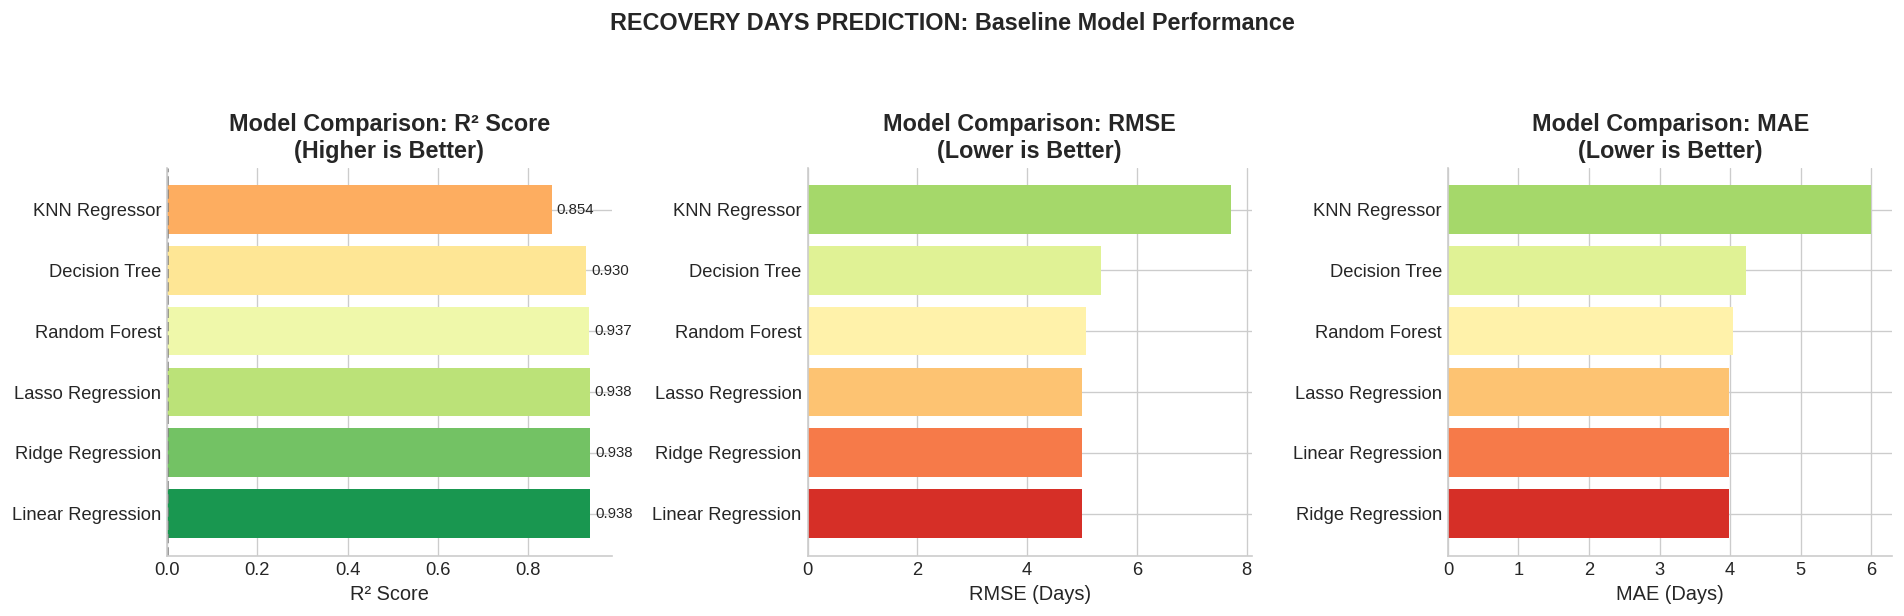


Best Baseline Model: Linear Regression (R² = 0.9384)


In [18]:
# Scale features
scaler_rec = RobustScaler()
X_train_rec_scaled = scaler_rec.fit_transform(X_train_rec)
X_test_rec_scaled = scaler_rec.transform(X_test_rec)

# Define baseline models
baseline_models_reg = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15,
                                            random_state=RANDOM_STATE, n_jobs=-1)
}

# Train and evaluate
results_recovery = []

print("=" * 70)
print("RECOVERY DAYS PREDICTION - BASELINE MODELS")
print("=" * 70)
print(f"\n{'Model':<25} {'RMSE':<12} {'MAE':<12} {'R² Score':<12}")
print("-" * 65)

for name, model in baseline_models_reg.items():
    # Train
    if 'Linear' in name or 'Ridge' in name or 'Lasso' in name or 'KNN' in name:
        model.fit(X_train_rec_scaled, y_train_rec)
        y_pred = model.predict(X_test_rec_scaled)
    else:
        model.fit(X_train_rec, y_train_rec)
        y_pred = model.predict(X_test_rec)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_rec, y_pred))
    mae = mean_absolute_error(y_test_rec, y_pred)
    r2 = r2_score(y_test_rec, y_pred)

    results_recovery.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

    print(f"{name:<25} {rmse:<12.4f} {mae:<12.4f} {r2:<12.4f}")

# Visualize results
results_df_rec = pd.DataFrame(results_recovery).sort_values('R2', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R² Score comparison
ax1 = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(results_df_rec)))[::-1]
bars = ax1.barh(results_df_rec['Model'], results_df_rec['R2'], color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('Model Comparison: R² Score\n(Higher is Better)', fontweight='bold')
ax1.axvline(x=0, color='gray', linestyle='--')
for bar, val in zip(bars, results_df_rec['R2']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# RMSE comparison
ax2 = axes[1]
results_sorted_rmse = results_df_rec.sort_values('RMSE', ascending=True)
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(results_sorted_rmse)))[::-1]
bars = ax2.barh(results_sorted_rmse['Model'], results_sorted_rmse['RMSE'], color=colors)
ax2.set_xlabel('RMSE (Days)')
ax2.set_title('Model Comparison: RMSE\n(Lower is Better)', fontweight='bold')

# MAE comparison
ax3 = axes[2]
results_sorted_mae = results_df_rec.sort_values('MAE', ascending=True)
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(results_sorted_mae)))[::-1]
bars = ax3.barh(results_sorted_mae['Model'], results_sorted_mae['MAE'], color=colors)
ax3.set_xlabel('MAE (Days)')
ax3.set_title('Model Comparison: MAE\n(Lower is Better)', fontweight='bold')

plt.suptitle('RECOVERY DAYS PREDICTION: Baseline Model Performance\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

best_model_rec = results_df_rec.iloc[0]['Model']
best_r2_rec = results_df_rec.iloc[0]['R2']
print(f"\nBest Baseline Model: {best_model_rec} (R² = {best_r2_rec:.4f})")

## Advanced Models - Recovery Days with XGBoost and LightGBM

RECOVERY DAYS - ADVANCED MODELS

Model                     RMSE         MAE          R² Score     Train Time  
---------------------------------------------------------------------------
XGBoost                   5.1641       4.0995       0.9343       9.84        s
LightGBM                  5.0420       4.0177       0.9374       1.44        s
Gradient Boosting         5.0510       4.0178       0.9372       187.30      s
Extra Trees               5.0789       4.0420       0.9365       56.05       s


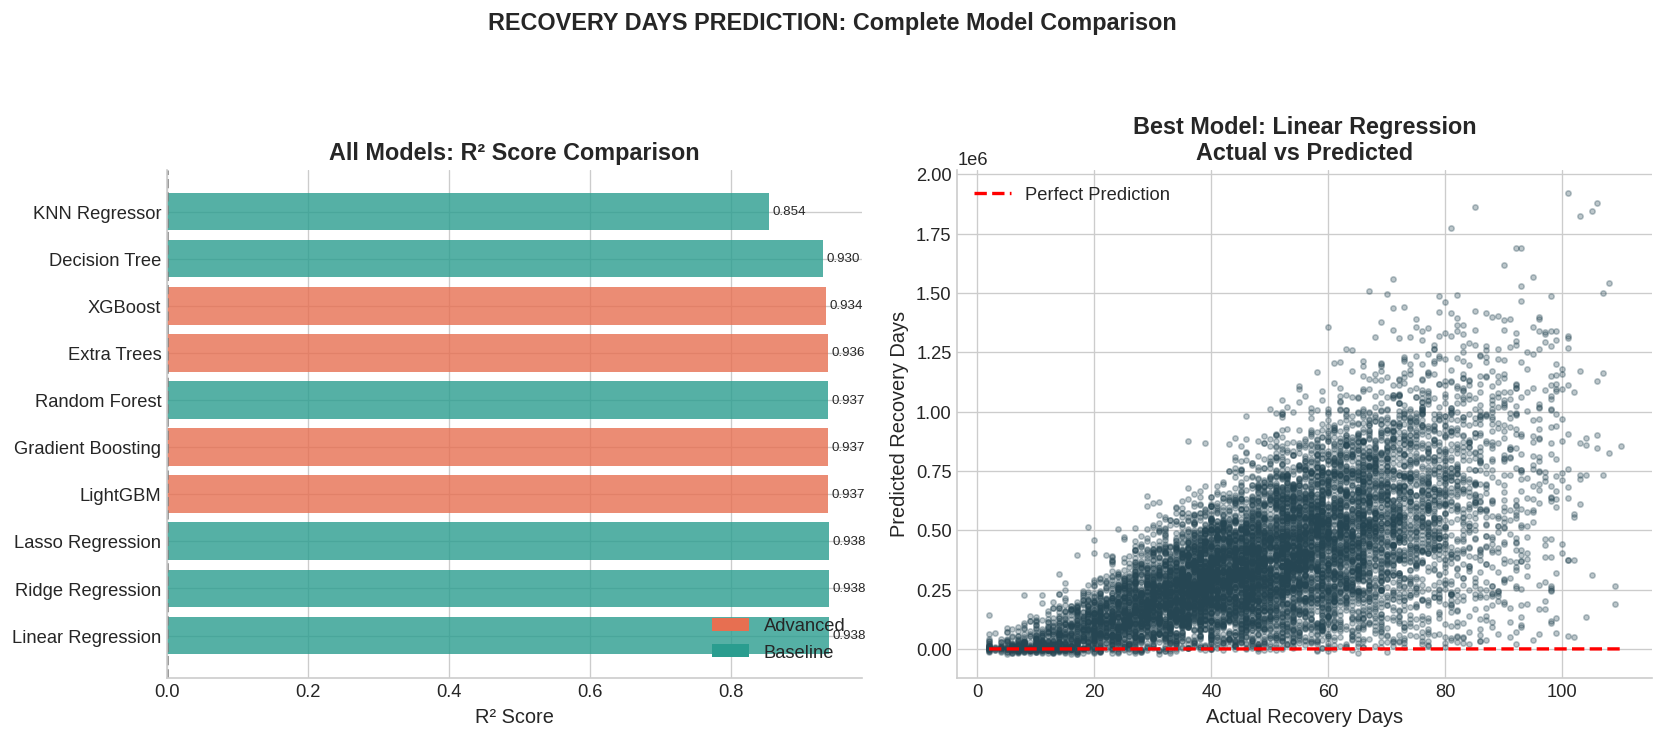


Best Overall Model: Linear Regression
Best R² Score: 0.9384
Best RMSE: 4.9990 days


In [19]:
# Advanced models
advanced_models_reg = {}

if XGB_AVAILABLE:
    advanced_models_reg['XGBoost'] = XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    )

if LGBM_AVAILABLE:
    advanced_models_reg['LightGBM'] = LGBMRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )

# Add Gradient Boosting and Extra Trees
advanced_models_reg['Gradient Boosting'] = GradientBoostingRegressor(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

advanced_models_reg['Extra Trees'] = ExtraTreesRegressor(
    n_estimators=150,
    max_depth=15,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("=" * 70)
print("RECOVERY DAYS - ADVANCED MODELS")
print("=" * 70)
print(f"\n{'Model':<25} {'RMSE':<12} {'MAE':<12} {'R² Score':<12} {'Train Time':<12}")
print("-" * 75)

import time
results_advanced_rec = []

for name, model in advanced_models_reg.items():
    start_time = time.time()
    model.fit(X_train_rec, y_train_rec)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test_rec)

    rmse = np.sqrt(mean_squared_error(y_test_rec, y_pred))
    mae = mean_absolute_error(y_test_rec, y_pred)
    r2 = r2_score(y_test_rec, y_pred)

    results_advanced_rec.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Train_Time': train_time
    })

    print(f"{name:<25} {rmse:<12.4f} {mae:<12.4f} {r2:<12.4f} {train_time:<12.2f}s")

# Combine all results
all_results_rec = results_recovery + results_advanced_rec
all_results_df_rec = pd.DataFrame(all_results_rec).sort_values('R2', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# All models comparison
ax1 = axes[0]
colors = ['#E76F51' if 'XGBoost' in m or 'LightGBM' in m or 'Gradient' in m or 'Extra' in m
          else '#2A9D8F' for m in all_results_df_rec['Model']]
bars = ax1.barh(all_results_df_rec['Model'], all_results_df_rec['R2'], color=colors, alpha=0.8)
ax1.set_xlabel('R² Score')
ax1.set_title('All Models: R² Score Comparison', fontweight='bold')
ax1.axvline(x=0, color='gray', linestyle='--')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#E76F51', label='Advanced'),
                   Patch(facecolor='#2A9D8F', label='Baseline')]
ax1.legend(handles=legend_elements, loc='lower right')

for bar, val in zip(bars, all_results_df_rec['R2']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=8)

# Actual vs Predicted for best model
ax2 = axes[1]
best_model_name = all_results_df_rec.iloc[0]['Model']
if best_model_name in advanced_models_reg:
    best_model = advanced_models_reg[best_model_name]
else:
    best_model = baseline_models_reg[best_model_name]

y_pred_best = best_model.predict(X_test_rec)

ax2.scatter(y_test_rec, y_pred_best, alpha=0.3, s=10, c='#264653')
ax2.plot([y_test_rec.min(), y_test_rec.max()], [y_test_rec.min(), y_test_rec.max()],
        'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Recovery Days')
ax2.set_ylabel('Predicted Recovery Days')
ax2.set_title(f'Best Model: {best_model_name}\nActual vs Predicted', fontweight='bold')
ax2.legend()

plt.suptitle('RECOVERY DAYS PREDICTION: Complete Model Comparison\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nBest Overall Model: {all_results_df_rec.iloc[0]['Model']}")
print(f"Best R² Score: {all_results_df_rec.iloc[0]['R2']:.4f}")
print(f"Best RMSE: {all_results_df_rec.iloc[0]['RMSE']:.4f} days")

## Casualty Level Classification

CASUALTY LEVEL CLASSIFICATION

Classes: ['High' 'Low' 'Medium' nan]

Model                     Accuracy     F1-Macro     F1-Weighted 
-----------------------------------------------------------------
Logistic Regression       0.6314       0.4168       0.6098      
Decision Tree             0.6159       0.3957       0.5886      
Random Forest             0.6287       0.4100       0.6038      
Gradient Boosting         0.6273       0.4191       0.6027      
Extra Trees               0.6302       0.4112       0.6053      
XGBoost                   0.6223       0.4055       0.5982      
LightGBM                  0.6206       0.4028       0.5954      


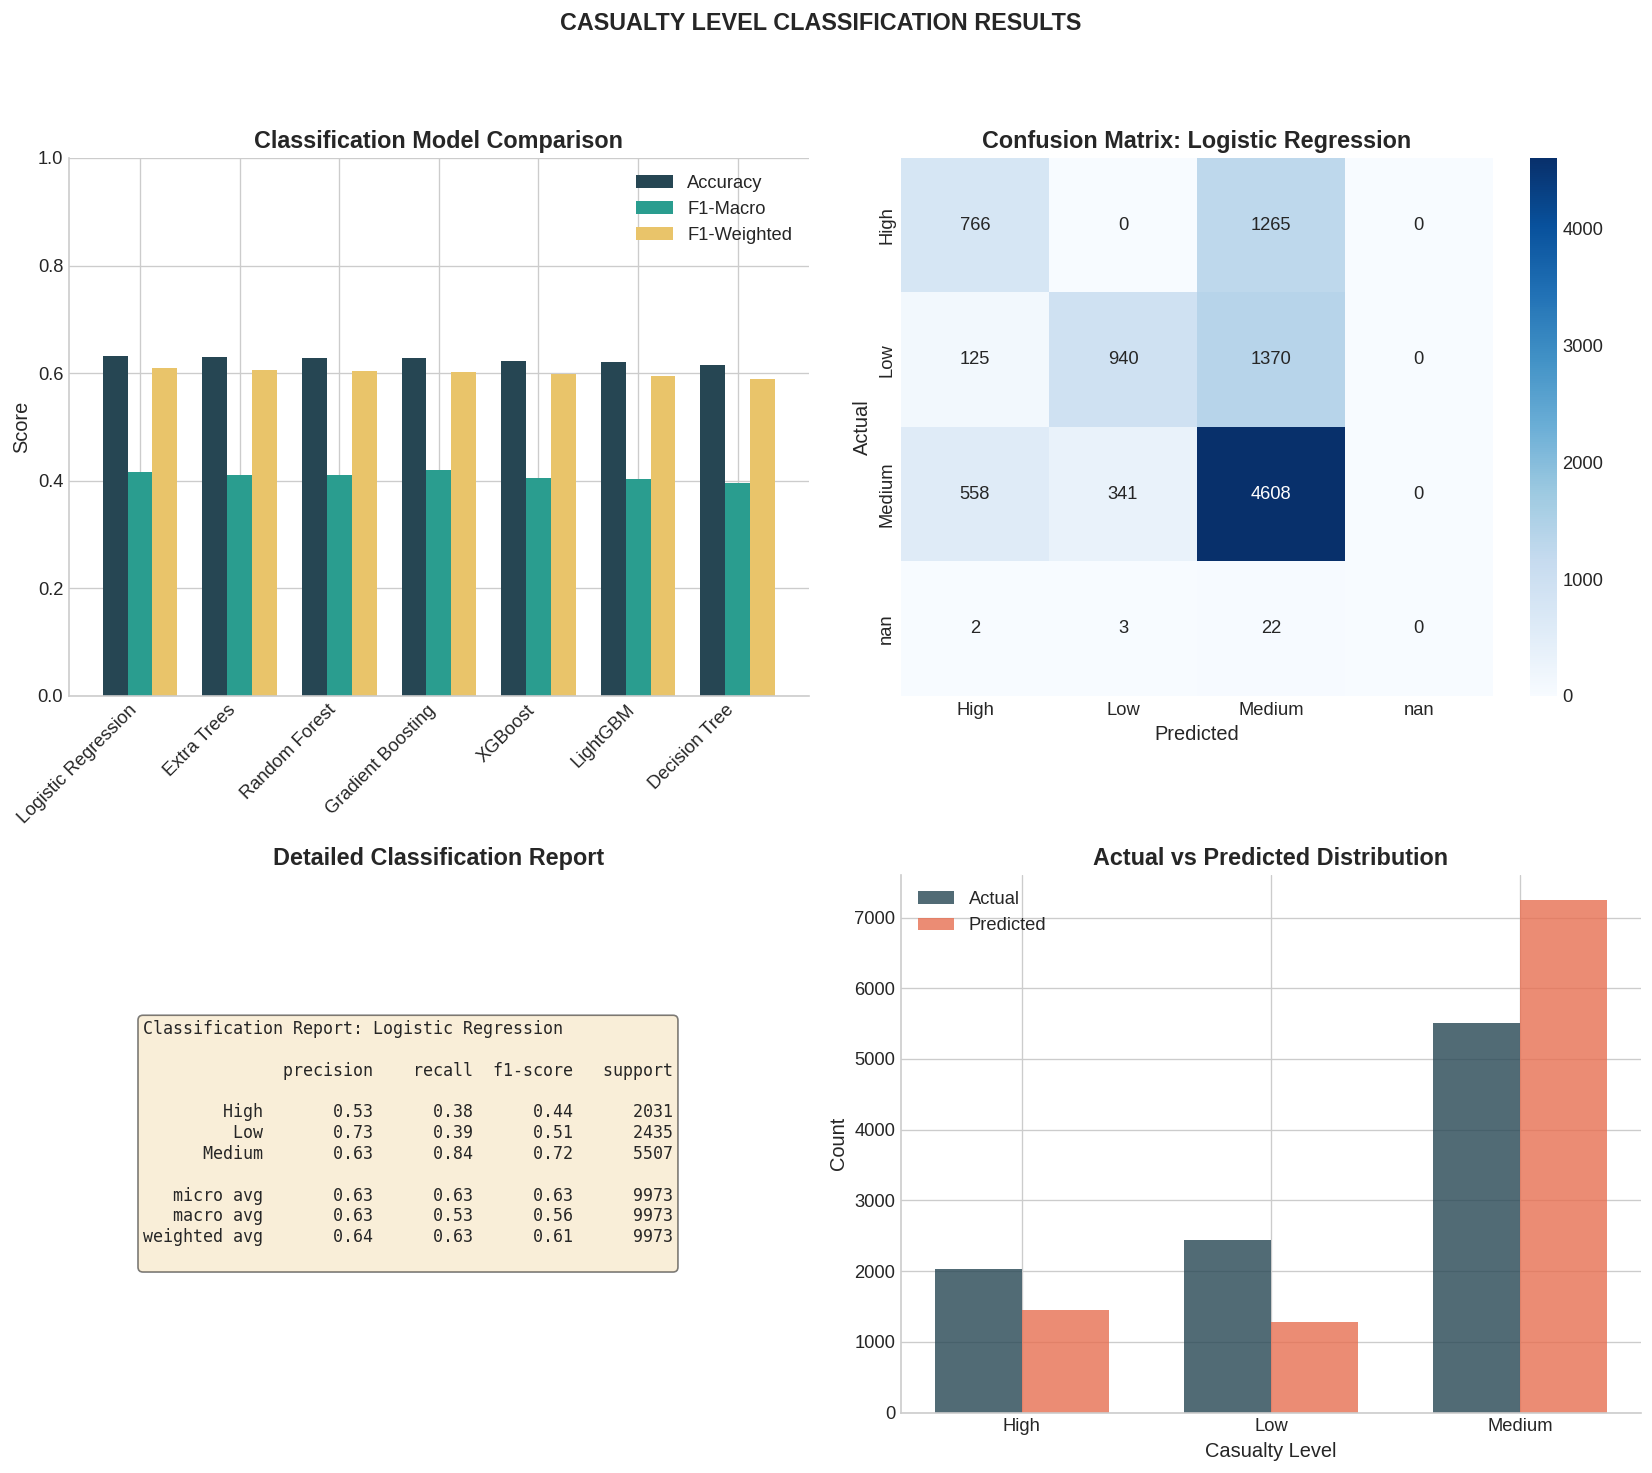


Best Classification Model: Logistic Regression
Best Accuracy: 0.6314
Best F1-Weighted: 0.6098


In [23]:
# Scale features for models that need it
scaler_cas = RobustScaler()
X_train_cas_scaled = scaler_cas.fit_transform(X_train_cas)
X_test_cas_scaled = scaler_cas.transform(X_test_cas)

# Define classification models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15,
                                             random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=6,
                                                     random_state=RANDOM_STATE),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, max_depth=15,
                                         random_state=RANDOM_STATE, n_jobs=-1)
}

if XGB_AVAILABLE:
    classification_models['XGBoost'] = XGBClassifier(
        n_estimators=150,
        max_depth=8,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

if LGBM_AVAILABLE:
    classification_models['LightGBM'] = LGBMClassifier(
        n_estimators=150,
        max_depth=8,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )

print("=" * 70)
print("CASUALTY LEVEL CLASSIFICATION")
print("=" * 70)
print(f"\nClasses: {le_casualty.classes_}")
print(f"\n{'Model':<25} {'Accuracy':<12} {'F1-Macro':<12} {'F1-Weighted':<12}")
print("-" * 65)

results_classification = []

for name, model in classification_models.items():
    # Train
    if 'Logistic' in name:
        model.fit(X_train_cas_scaled, y_train_cas)
        y_pred = model.predict(X_test_cas_scaled)
    else:
        model.fit(X_train_cas, y_train_cas)
        y_pred = model.predict(X_test_cas)

    # Metrics
    accuracy = accuracy_score(y_test_cas, y_pred)
    f1_macro = f1_score(y_test_cas, y_pred, average='macro')
    f1_weighted = f1_score(y_test_cas, y_pred, average='weighted')

    results_classification.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1_Macro': f1_macro,
        'F1_Weighted': f1_weighted
    })

    print(f"{name:<25} {accuracy:<12.4f} {f1_macro:<12.4f} {f1_weighted:<12.4f}")

results_df_cls = pd.DataFrame(results_classification).sort_values('F1_Weighted', ascending=False)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Model comparison
ax1 = axes[0, 0]
x = np.arange(len(results_df_cls))
width = 0.25

bars1 = ax1.bar(x - width, results_df_cls['Accuracy'], width, label='Accuracy', color='#264653')
bars2 = ax1.bar(x, results_df_cls['F1_Macro'], width, label='F1-Macro', color='#2A9D8F')
bars3 = ax1.bar(x + width, results_df_cls['F1_Weighted'], width, label='F1-Weighted', color='#E9C46A')

ax1.set_ylabel('Score')
ax1.set_title('Classification Model Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df_cls['Model'], rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)

# Confusion Matrix for best model
ax2 = axes[0, 1]
best_cls_model_name = results_df_cls.iloc[0]['Model']
best_cls_model = classification_models[best_cls_model_name]

if 'Logistic' in best_cls_model_name:
    y_pred_best_cls = best_cls_model.predict(X_test_cas_scaled)
else:
    y_pred_best_cls = best_cls_model.predict(X_test_cas)

cm = confusion_matrix(y_test_cas, y_pred_best_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=le_casualty.classes_, yticklabels=le_casualty.classes_)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title(f'Confusion Matrix: {best_cls_model_name}', fontweight='bold')

# Classification Report
ax3 = axes[1, 0]
ax3.axis('off')

# Filter out nan from le_casualty.classes_ for target_names
filtered_target_names = [str(cls) for cls in le_casualty.classes_ if pd.notna(cls)]
# Get numerical labels corresponding to the filtered target names
numerical_labels_to_report = [i for i, cls in enumerate(le_casualty.classes_) if pd.notna(cls)]

report = classification_report(y_test_cas, y_pred_best_cls,
                               labels=numerical_labels_to_report, # Explicitly pass labels
                               target_names=filtered_target_names)
ax3.text(0.1, 0.5, f"Classification Report: {best_cls_model_name}\n\n{report}",
         fontfamily='monospace', fontsize=10, verticalalignment='center',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax3.set_title('Detailed Classification Report', fontweight='bold')

# Class distribution in predictions
ax4 = axes[1, 1]

# Determine which label corresponds to NaN and filter it out for plotting
nan_label = None
for i, cls_name in enumerate(le_casualty.classes_):
    if pd.isna(cls_name):
        nan_label = i
        break

if nan_label is not None:
    mask_valid_actual = (y_test_cas != nan_label)
    y_test_cas_filtered = y_test_cas[mask_valid_actual]
    y_pred_best_cls_filtered = y_pred_best_cls[mask_valid_actual]
else:
    y_test_cas_filtered = y_test_cas
    y_pred_best_cls_filtered = y_pred_best_cls

# Recalculate distributions using filtered data and reindex to ensure all valid classes are present
pred_dist = pd.Series(y_pred_best_cls_filtered).value_counts().sort_index()
actual_dist = pd.Series(y_test_cas_filtered).value_counts().sort_index()

all_valid_labels = sorted(numerical_labels_to_report)
pred_dist = pred_dist.reindex(all_valid_labels, fill_value=0)
actual_dist = actual_dist.reindex(all_valid_labels, fill_value=0)

x = np.arange(len(filtered_target_names))
width = 0.35

ax4.bar(x - width/2, actual_dist.values, width, label='Actual', color='#264653', alpha=0.8)
ax4.bar(x + width/2, pred_dist.values, width, label='Predicted', color='#E76F51', alpha=0.8)

ax4.set_xlabel('Casualty Level')
ax4.set_ylabel('Count')
ax4.set_title('Actual vs Predicted Distribution', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(filtered_target_names) # Use filtered names for tick labels
ax4.legend()

plt.suptitle('CASUALTY LEVEL CLASSIFICATION RESULTS\n', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nBest Classification Model: {best_cls_model_name}")
print(f"Best Accuracy: {results_df_cls.iloc[0]['Accuracy']:.4f}")
print(f"Best F1-Weighted: {results_df_cls.iloc[0]['F1_Weighted']:.4f}")

##  Economic Loss Prediction

ECONOMIC LOSS PREDICTION (Log-Transformed)

Model                     RMSE(log)    MAE(log)     R² Score    
-----------------------------------------------------------------
Ridge Regression          0.7578       0.5158       0.2733      
Random Forest             0.7619       0.5229       0.2655      
Gradient Boosting         0.7631       0.5205       0.2632      
Extra Trees               0.7642       0.5274       0.2610      
XGBoost                   0.7755       0.5323       0.2391      
LightGBM                  0.7603       0.5183       0.2685      


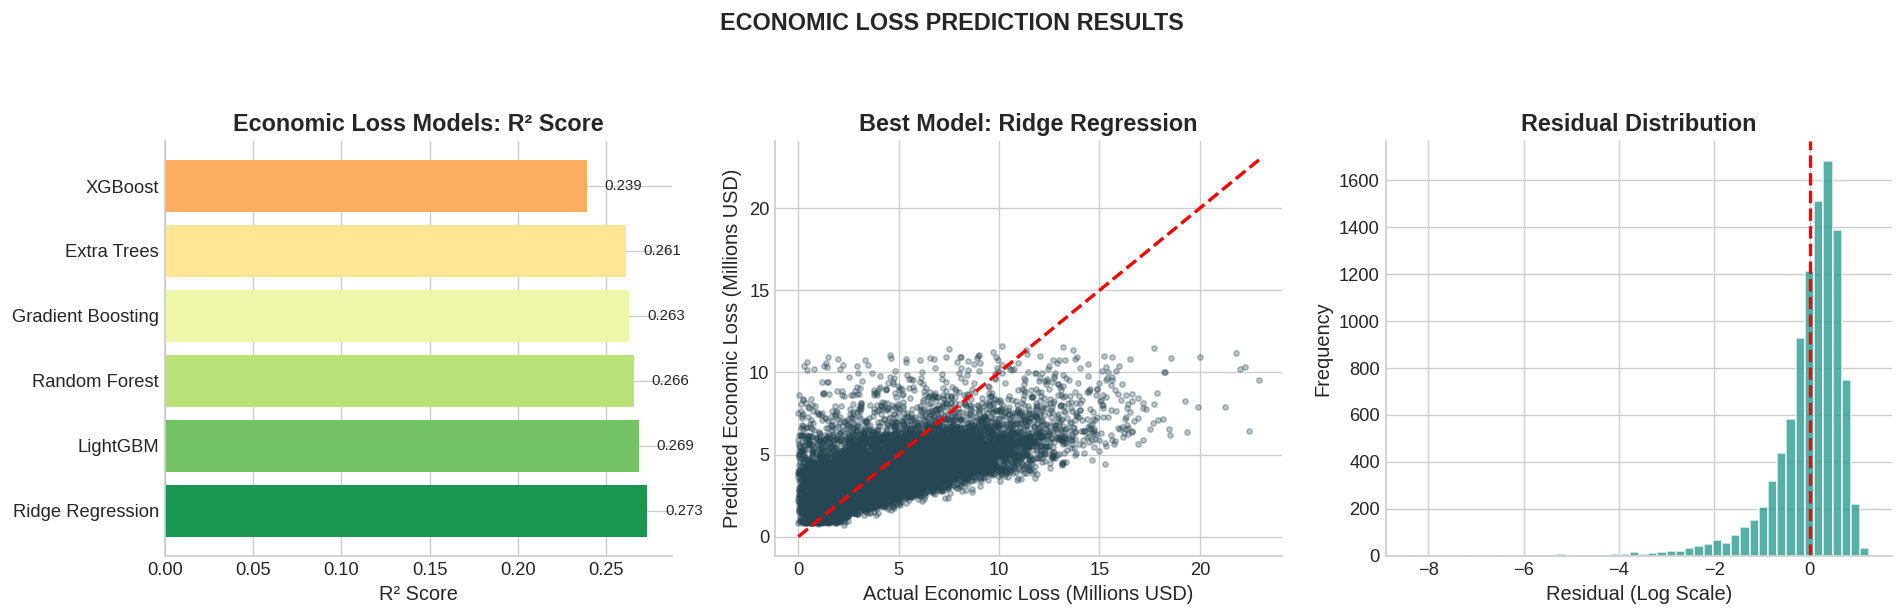


Best Model: Ridge Regression
Best R² Score: 0.2733


In [24]:
# Advanced models for economic loss
loss_models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=150, max_depth=15,
                                            random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=150, max_depth=6,
                                                    learning_rate=0.1, random_state=RANDOM_STATE),
    'Extra Trees': ExtraTreesRegressor(n_estimators=150, max_depth=15,
                                        random_state=RANDOM_STATE, n_jobs=-1)
}

if XGB_AVAILABLE:
    loss_models['XGBoost'] = XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    )

if LGBM_AVAILABLE:
    loss_models['LightGBM'] = LGBMRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )

# Scale for linear models
scaler_loss = RobustScaler()
X_train_loss_scaled = scaler_loss.fit_transform(X_train_loss)
X_test_loss_scaled = scaler_loss.transform(X_test_loss)

print("=" * 70)
print("ECONOMIC LOSS PREDICTION (Log-Transformed)")
print("=" * 70)
print(f"\n{'Model':<25} {'RMSE(log)':<12} {'MAE(log)':<12} {'R² Score':<12}")
print("-" * 65)

results_loss = []

for name, model in loss_models.items():
    if 'Ridge' in name:
        model.fit(X_train_loss_scaled, y_train_loss)
        y_pred = model.predict(X_test_loss_scaled)
    else:
        model.fit(X_train_loss, y_train_loss)
        y_pred = model.predict(X_test_loss)

    rmse = np.sqrt(mean_squared_error(y_test_loss, y_pred))
    mae = mean_absolute_error(y_test_loss, y_pred)
    r2 = r2_score(y_test_loss, y_pred)

    results_loss.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

    print(f"{name:<25} {rmse:<12.4f} {mae:<12.4f} {r2:<12.4f}")

results_df_loss = pd.DataFrame(results_loss).sort_values('R2', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R² comparison
ax1 = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(results_df_loss)))[::-1]
bars = ax1.barh(results_df_loss['Model'], results_df_loss['R2'], color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('Economic Loss Models: R² Score', fontweight='bold')
for bar, val in zip(bars, results_df_loss['R2']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Actual vs Predicted (best model)
ax2 = axes[1]
best_loss_model_name = results_df_loss.iloc[0]['Model']
best_loss_model = loss_models[best_loss_model_name]

if 'Ridge' in best_loss_model_name:
    y_pred_best_loss = best_loss_model.predict(X_test_loss_scaled)
else:
    y_pred_best_loss = best_loss_model.predict(X_test_loss)

# Convert back from log scale for visualization
y_test_original = np.expm1(y_test_loss)
y_pred_original = np.expm1(y_pred_best_loss)

ax2.scatter(y_test_original/1e6, y_pred_original/1e6, alpha=0.3, s=10, c='#264653')
max_val = max(y_test_original.max(), y_pred_original.max())/1e6
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
ax2.set_xlabel('Actual Economic Loss (Millions USD)')
ax2.set_ylabel('Predicted Economic Loss (Millions USD)')
ax2.set_title(f'Best Model: {best_loss_model_name}', fontweight='bold')

# Residuals
ax3 = axes[2]
residuals = y_test_loss - y_pred_best_loss
ax3.hist(residuals, bins=50, color='#2A9D8F', edgecolor='white', alpha=0.8)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Residual (Log Scale)')
ax3.set_ylabel('Frequency')
ax3.set_title('Residual Distribution', fontweight='bold')

plt.suptitle('ECONOMIC LOSS PREDICTION RESULTS\n', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_loss_model_name}")
print(f"Best R² Score: {results_df_loss.iloc[0]['R2']:.4f}")

## Feature Importance Analysis

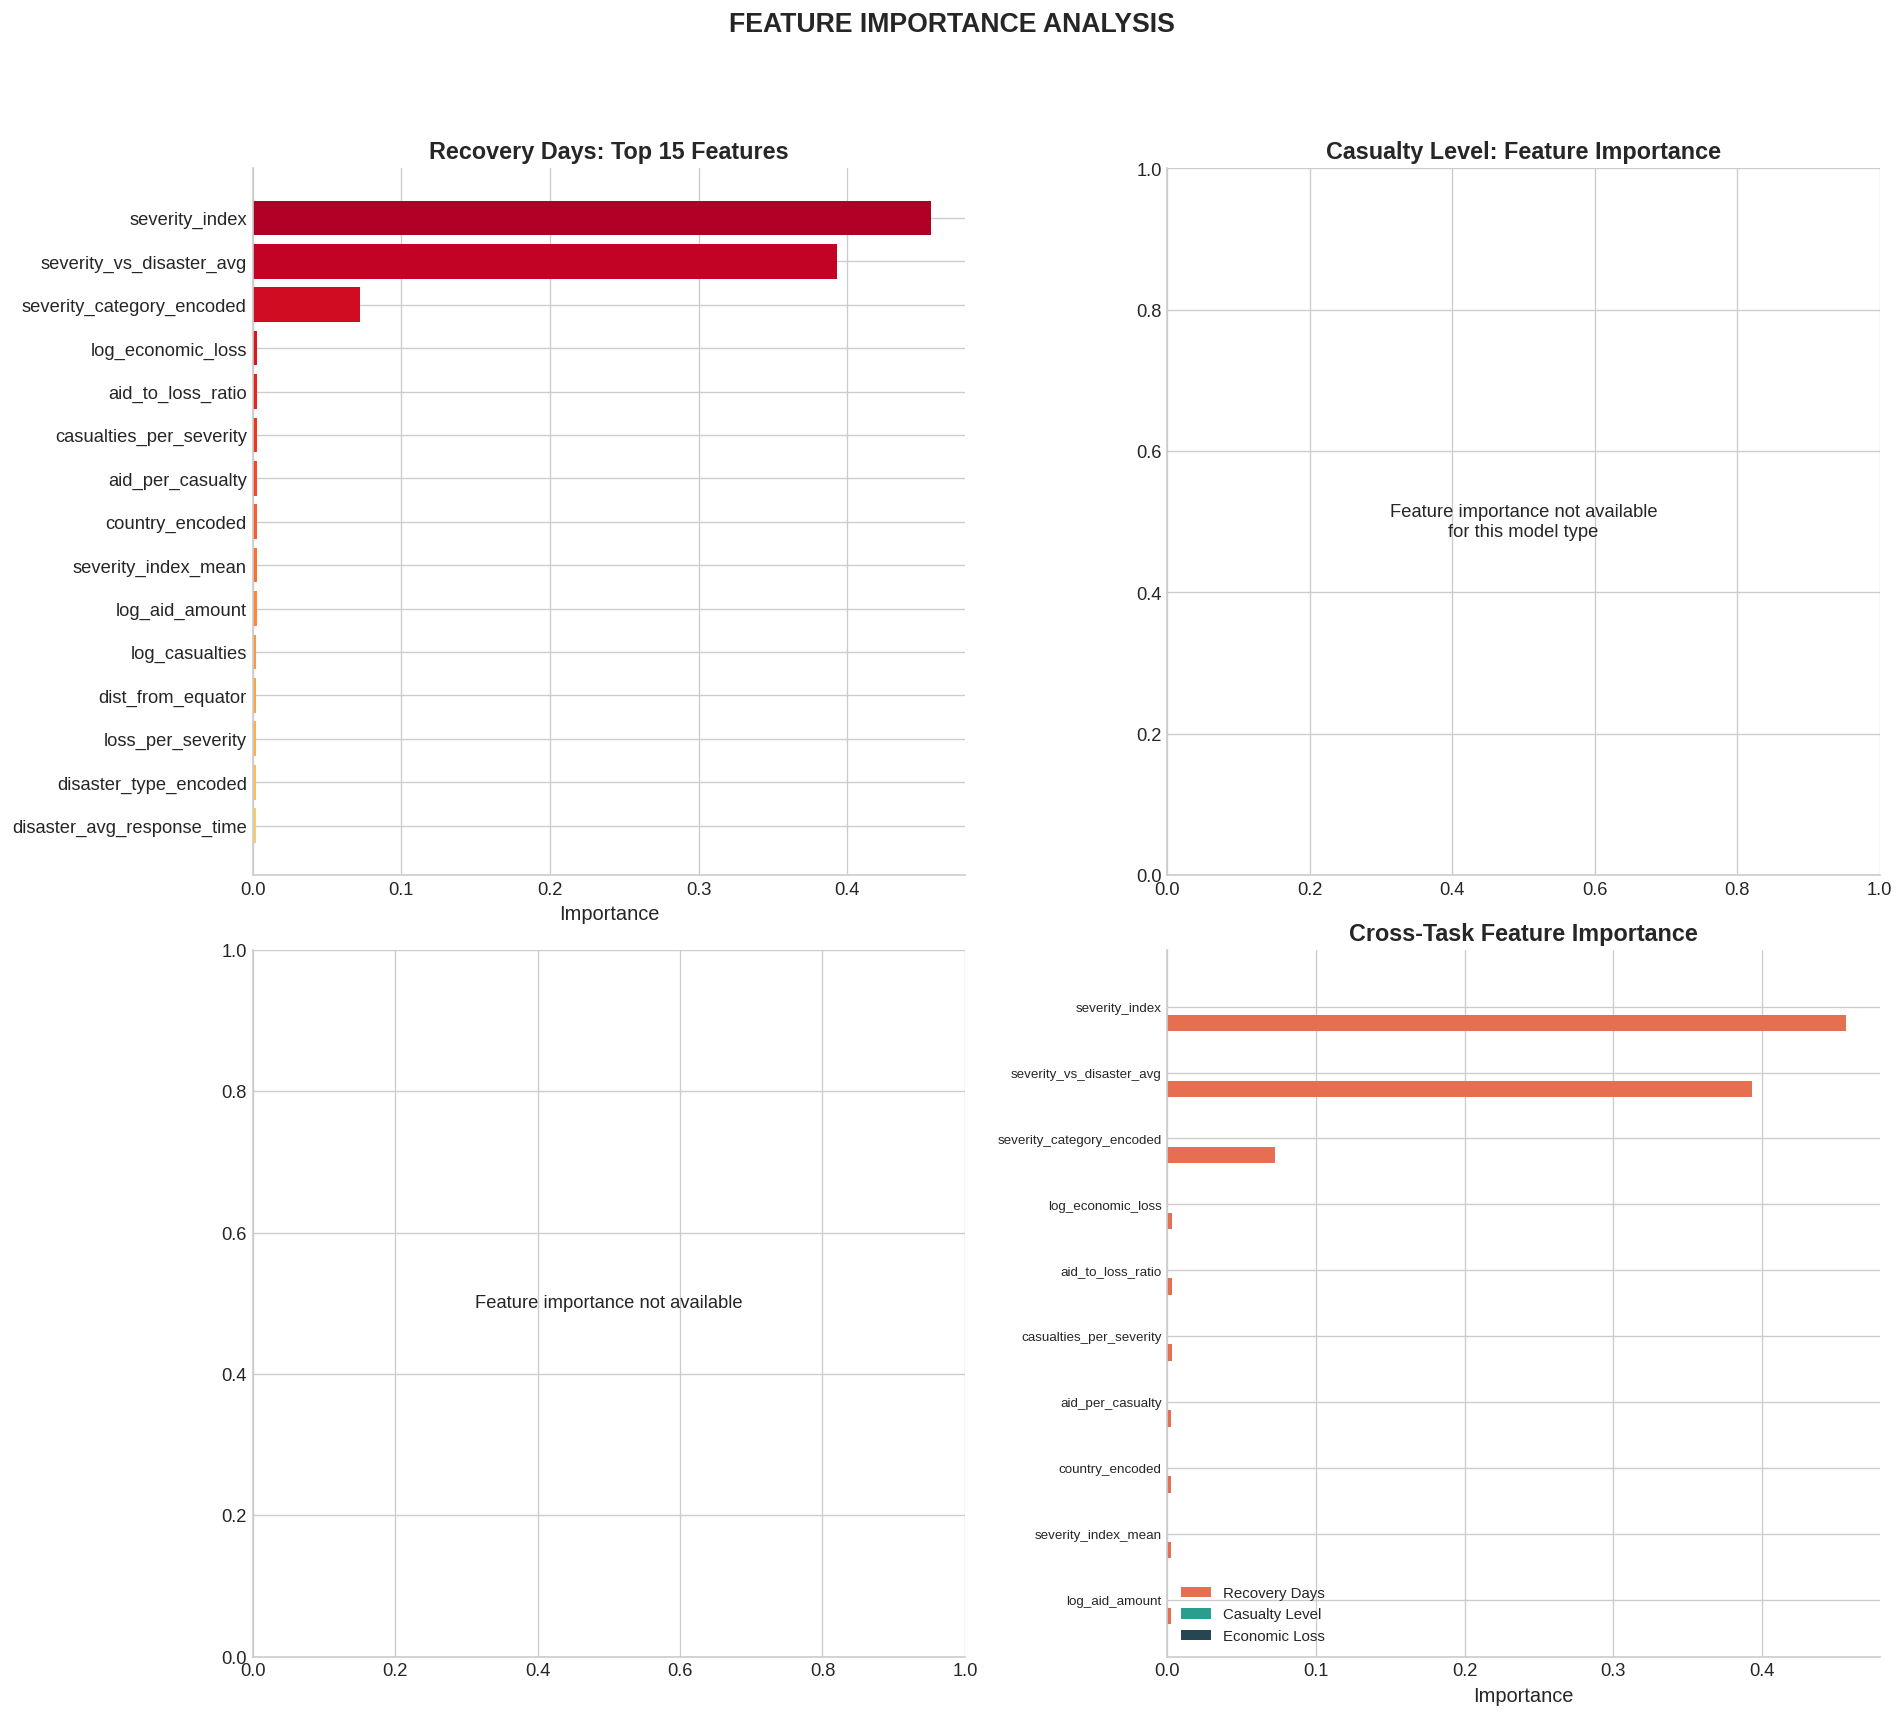


KEY FEATURE IMPORTANCE INSIGHTS

Top 5 Features for Recovery Days Prediction:
  - severity_index: 0.4565
  - severity_vs_disaster_avg: 0.3935
  - severity_category_encoded: 0.0723
  - log_economic_loss: 0.0029
  - aid_to_loss_ratio: 0.0027

Top 5 Features for Casualty Classification:

Top 5 Features for Economic Loss Prediction:


In [25]:
# Get feature importance from best models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))


# Panel 1: Recovery Days - Feature Importance
ax1 = axes[0, 0]

# Use the best tree-based model for recovery
if 'XGBoost' in advanced_models_reg:
    model_rec = advanced_models_reg['XGBoost']
elif 'LightGBM' in advanced_models_reg:
    model_rec = advanced_models_reg['LightGBM']
else:
    model_rec = advanced_models_reg['Random Forest']

importance_rec = pd.DataFrame({
    'feature': X_train_rec.columns,
    'importance': model_rec.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(importance_rec)))
ax1.barh(importance_rec['feature'], importance_rec['importance'], color=colors)
ax1.set_xlabel('Importance')
ax1.set_title('Recovery Days: Top 15 Features', fontweight='bold')


# Panel 2: Casualty Classification - Feature Importance
ax2 = axes[0, 1]

# Use best classification model
best_cls_for_importance = classification_models[best_cls_model_name]
if hasattr(best_cls_for_importance, 'feature_importances_'):
    importance_cls = pd.DataFrame({
        'feature': X_train_cas.columns,
        'importance': best_cls_for_importance.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)

    colors = plt.cm.YlGnBu(np.linspace(0.3, 0.9, len(importance_cls)))
    ax2.barh(importance_cls['feature'], importance_cls['importance'], color=colors)
    ax2.set_xlabel('Importance')
    ax2.set_title('Casualty Level: Top 15 Features', fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'Feature importance not available\nfor this model type',
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Casualty Level: Feature Importance', fontweight='bold')


# Panel 3: Economic Loss - Feature Importance
ax3 = axes[1, 0]

if hasattr(best_loss_model, 'feature_importances_'):
    importance_loss = pd.DataFrame({
        'feature': X_train_loss.columns,
        'importance': best_loss_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)

    colors = plt.cm.Purples(np.linspace(0.3, 0.9, len(importance_loss)))
    ax3.barh(importance_loss['feature'], importance_loss['importance'], color=colors)
    ax3.set_xlabel('Importance')
    ax3.set_title('Economic Loss: Top 15 Features', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Feature importance not available',
             ha='center', va='center', transform=ax3.transAxes)


# Panel 4: Cross-Task Feature Importance Comparison
ax4 = axes[1, 1]

# Get top 10 features from each task and find common ones
top_rec = set(importance_rec.tail(10)['feature'].tolist())
top_cls = set(importance_cls.tail(10)['feature'].tolist()) if 'importance_cls' in dir() else set()
top_loss = set(importance_loss.tail(10)['feature'].tolist()) if 'importance_loss' in dir() else set()

# Create comparison dataframe
all_top_features = list(top_rec | top_cls | top_loss)

comparison_data = []
for feat in all_top_features:
    rec_imp = importance_rec[importance_rec['feature'] == feat]['importance'].values
    cls_imp = importance_cls[importance_cls['feature'] == feat]['importance'].values if 'importance_cls' in dir() else []
    loss_imp = importance_loss[importance_loss['feature'] == feat]['importance'].values if 'importance_loss' in dir() else []

    comparison_data.append({
        'feature': feat,
        'Recovery': rec_imp[0] if len(rec_imp) > 0 else 0,
        'Classification': cls_imp[0] if len(cls_imp) > 0 else 0,
        'Economic Loss': loss_imp[0] if len(loss_imp) > 0 else 0
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df['total'] = comparison_df['Recovery'] + comparison_df['Classification'] + comparison_df['Economic Loss']
comparison_df = comparison_df.sort_values('total', ascending=True).tail(10)

x = np.arange(len(comparison_df))
width = 0.25

ax4.barh(x - width, comparison_df['Recovery'], width, label='Recovery Days', color='#E76F51')
ax4.barh(x, comparison_df['Classification'], width, label='Casualty Level', color='#2A9D8F')
ax4.barh(x + width, comparison_df['Economic Loss'], width, label='Economic Loss', color='#264653')

ax4.set_yticks(x)
ax4.set_yticklabels(comparison_df['feature'], fontsize=8)
ax4.set_xlabel('Importance')
ax4.set_title('Cross-Task Feature Importance', fontweight='bold')
ax4.legend(fontsize=9)

plt.suptitle('FEATURE IMPORTANCE ANALYSIS\n', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Key insights
print("\n" + "=" * 70)
print("KEY FEATURE IMPORTANCE INSIGHTS")
print("=" * 70)
print("\nTop 5 Features for Recovery Days Prediction:")
for i, row in importance_rec.tail(5).iloc[::-1].iterrows():
    print(f"  - {row['feature']}: {row['importance']:.4f}")

print("\nTop 5 Features for Casualty Classification:")
if 'importance_cls' in dir():
    for i, row in importance_cls.tail(5).iloc[::-1].iterrows():
        print(f"  - {row['feature']}: {row['importance']:.4f}")

print("\nTop 5 Features for Economic Loss Prediction:")
if 'importance_loss' in dir():
    for i, row in importance_loss.tail(5).iloc[::-1].iterrows():
        print(f"  - {row['feature']}: {row['importance']:.4f}")

## Hyperparameter Tuning

HYPERPARAMETER TUNING: XGBoost for Recovery Days

Running RandomizedSearchCV (this may take a few minutes)...
Sample size for tuning: 10,000
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best CV Score (R²): 0.9365

----------------------------------------------------------------------
TUNED MODEL PERFORMANCE (Full Test Set)
----------------------------------------------------------------------
RMSE: 5.0199
MAE:  3.9951
R²:   0.9379

----------------------------------------------------------------------
IMPROVEMENT FROM TUNING
----------------------------------------------------------------------
Metric          Before          After           Improvement    
------------------------------------------------------------
R²              0.9343          0.9379          +0.36%
RMSE            5.1641          5.0199          0.1442
MA

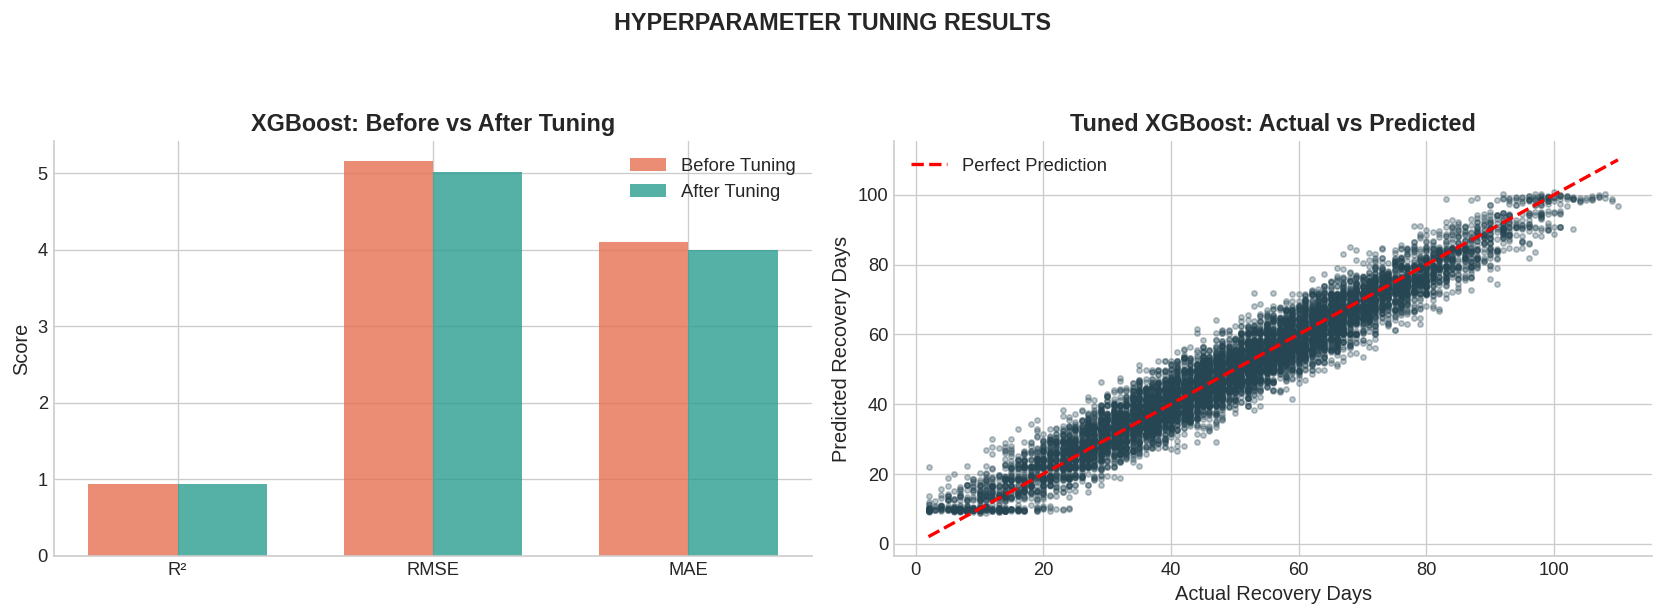

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# Tune XGBoost for Recovery Days
print("=" * 70)
print("HYPERPARAMETER TUNING: XGBoost for Recovery Days")
print("=" * 70)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

xgb_model = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)

# Use smaller sample for faster tuning
sample_size = min(10000, len(X_train_rec))
X_sample = X_train_rec.sample(sample_size, random_state=RANDOM_STATE)
y_sample = y_train_rec.loc[X_sample.index]

print("\nRunning RandomizedSearchCV (this may take a few minutes)...")
print(f"Sample size for tuning: {sample_size:,}")

random_search = RandomizedSearchCV(
    xgb_model,
    xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_sample, y_sample)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Score (R²): {random_search.best_score_:.4f}")

# Train final model with best params
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train_rec, y_train_rec)
y_pred_tuned = best_xgb.predict(X_test_rec)

rmse_tuned = np.sqrt(mean_squared_error(y_test_rec, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test_rec, y_pred_tuned)
r2_tuned = r2_score(y_test_rec, y_pred_tuned)

print("\n" + "-" * 70)
print("TUNED MODEL PERFORMANCE (Full Test Set)")
print("-" * 70)
print(f"RMSE: {rmse_tuned:.4f}")
print(f"MAE:  {mae_tuned:.4f}")
print(f"R²:   {r2_tuned:.4f}")

# Compare before and after tuning
print("\n" + "-" * 70)
print("IMPROVEMENT FROM TUNING")
print("-" * 70)

# Find original XGBoost results
original_xgb = [r for r in results_advanced_rec if r['Model'] == 'XGBoost'][0]
print(f"{'Metric':<15} {'Before':<15} {'After':<15} {'Improvement':<15}")
print("-" * 60)
print(f"{'R²':<15} {original_xgb['R2']:<15.4f} {r2_tuned:<15.4f} {(r2_tuned - original_xgb['R2'])*100:+.2f}%")
print(f"{'RMSE':<15} {original_xgb['RMSE']:<15.4f} {rmse_tuned:<15.4f} {(original_xgb['RMSE'] - rmse_tuned):.4f}")
print(f"{'MAE':<15} {original_xgb['MAE']:<15.4f} {mae_tuned:<15.4f} {(original_xgb['MAE'] - mae_tuned):.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before vs After
ax1 = axes[0]
metrics = ['R²', 'RMSE', 'MAE']
before = [original_xgb['R2'], original_xgb['RMSE'], original_xgb['MAE']]
after = [r2_tuned, rmse_tuned, mae_tuned]

x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, before, width, label='Before Tuning', color='#E76F51', alpha=0.8)
ax1.bar(x + width/2, after, width, label='After Tuning', color='#2A9D8F', alpha=0.8)

ax1.set_ylabel('Score')
ax1.set_title('XGBoost: Before vs After Tuning', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()

# Actual vs Predicted with tuned model
ax2 = axes[1]
ax2.scatter(y_test_rec, y_pred_tuned, alpha=0.3, s=10, c='#264653')
ax2.plot([y_test_rec.min(), y_test_rec.max()], [y_test_rec.min(), y_test_rec.max()],
        'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Recovery Days')
ax2.set_ylabel('Predicted Recovery Days')
ax2.set_title('Tuned XGBoost: Actual vs Predicted', fontweight='bold')
ax2.legend()

plt.suptitle('HYPERPARAMETER TUNING RESULTS\n', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Ensemble Model - Stacking

STACKING ENSEMBLE MODEL

Base Models: ['rf', 'gb', 'et', 'xgb', 'lgbm']
Meta-Learner: Ridge Regression

Training stacking ensemble (this may take a few minutes)...

Training Time: 751.28 seconds

Metric          Score          
------------------------------
RMSE            5.0249
MAE             3.9990
R²              0.9378

COMPLETE MODEL COMPARISON

Rank   Model                     R² Score     Type           
------------------------------------------------------------
1      Linear Regression         0.9384       Baseline       
2      XGBoost (Tuned)           0.9379       Tuned          
3      Stacking Ensemble         0.9378       Ensemble       
4      Random Forest             0.9365       Baseline       
5      XGBoost (Default)         0.9343       Advanced       


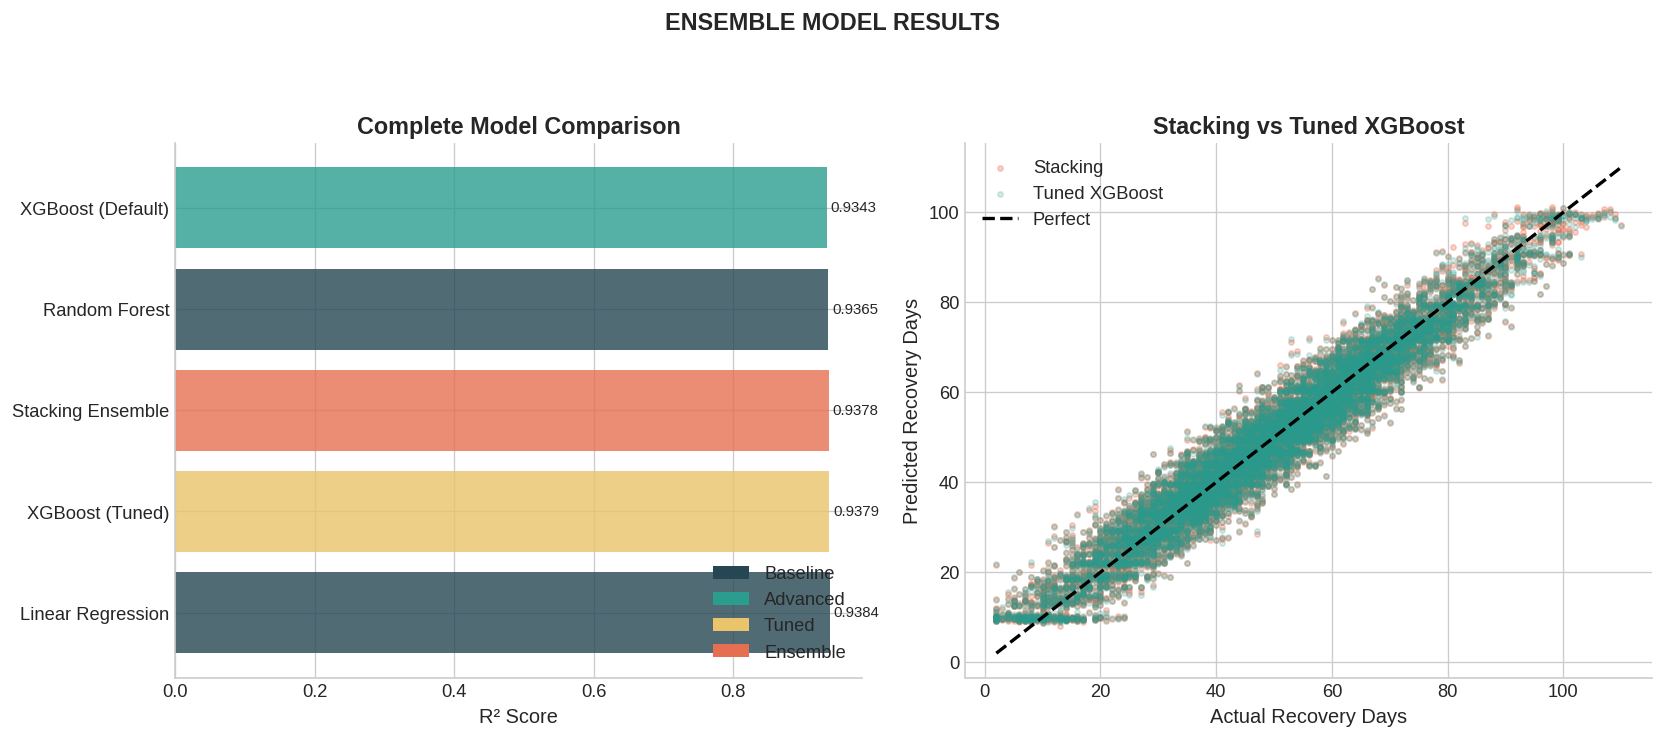


Best Overall Model: Linear Regression (R² = 0.9384)


In [27]:
from sklearn.ensemble import StackingRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)),
    ('et', ExtraTreesRegressor(n_estimators=100, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1))
]

if XGB_AVAILABLE:
    base_models.append(('xgb', XGBRegressor(n_estimators=100, max_depth=6,
                                             random_state=RANDOM_STATE, verbosity=0, n_jobs=-1)))

if LGBM_AVAILABLE:
    base_models.append(('lgbm', LGBMRegressor(n_estimators=100, max_depth=6,
                                               random_state=RANDOM_STATE, verbose=-1, n_jobs=-1)))

# Meta-learner
meta_learner = Ridge(alpha=1.0)

# Create stacking ensemble
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

print("=" * 70)
print("STACKING ENSEMBLE MODEL")
print("=" * 70)
print(f"\nBase Models: {[name for name, _ in base_models]}")
print(f"Meta-Learner: Ridge Regression")
print("\nTraining stacking ensemble (this may take a few minutes)...")

# Train
import time
start_time = time.time()
stacking_model.fit(X_train_rec, y_train_rec)
train_time = time.time() - start_time

# Predict
y_pred_stack = stacking_model.predict(X_test_rec)

# Metrics
rmse_stack = np.sqrt(mean_squared_error(y_test_rec, y_pred_stack))
mae_stack = mean_absolute_error(y_test_rec, y_pred_stack)
r2_stack = r2_score(y_test_rec, y_pred_stack)

print(f"\nTraining Time: {train_time:.2f} seconds")
print(f"\n{'Metric':<15} {'Score':<15}")
print("-" * 30)
print(f"{'RMSE':<15} {rmse_stack:.4f}")
print(f"{'MAE':<15} {mae_stack:.4f}")
print(f"{'R²':<15} {r2_stack:.4f}")

# Compare all approaches
print("\n" + "=" * 70)
print("COMPLETE MODEL COMPARISON")
print("=" * 70)

all_models_comparison = [
    {'Model': 'Linear Regression', 'R2': results_recovery[0]['R2'], 'Type': 'Baseline'},
    {'Model': 'Random Forest', 'R2': results_recovery[5]['R2'], 'Type': 'Baseline'},
    {'Model': 'XGBoost (Default)', 'R2': original_xgb['R2'], 'Type': 'Advanced'},
    {'Model': 'XGBoost (Tuned)', 'R2': r2_tuned, 'Type': 'Tuned'},
    {'Model': 'Stacking Ensemble', 'R2': r2_stack, 'Type': 'Ensemble'}
]

comparison_df = pd.DataFrame(all_models_comparison).sort_values('R2', ascending=False)

print(f"\n{'Rank':<6} {'Model':<25} {'R² Score':<12} {'Type':<15}")
print("-" * 60)
for i, row in comparison_df.iterrows():
    rank = comparison_df.index.get_loc(i) + 1
    print(f"{rank:<6} {row['Model']:<25} {row['R2']:<12.4f} {row['Type']:<15}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Model comparison
ax1 = axes[0]
colors = {'Baseline': '#264653', 'Advanced': '#2A9D8F', 'Tuned': '#E9C46A', 'Ensemble': '#E76F51'}
bar_colors = [colors[t] for t in comparison_df['Type']]

bars = ax1.barh(comparison_df['Model'], comparison_df['R2'], color=bar_colors, alpha=0.8)
ax1.set_xlabel('R² Score')
ax1.set_title('Complete Model Comparison', fontweight='bold')

for bar, val in zip(bars, comparison_df['R2']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[k], label=k) for k in colors.keys()]
ax1.legend(handles=legend_elements, loc='lower right')

# Stacking vs Best Single Model
ax2 = axes[1]
ax2.scatter(y_test_rec, y_pred_stack, alpha=0.3, s=10, c='#E76F51', label='Stacking')
ax2.scatter(y_test_rec, y_pred_tuned, alpha=0.2, s=10, c='#2A9D8F', label='Tuned XGBoost')
ax2.plot([y_test_rec.min(), y_test_rec.max()], [y_test_rec.min(), y_test_rec.max()],
        'k--', linewidth=2, label='Perfect')
ax2.set_xlabel('Actual Recovery Days')
ax2.set_ylabel('Predicted Recovery Days')
ax2.set_title('Stacking vs Tuned XGBoost', fontweight='bold')
ax2.legend()

plt.suptitle('ENSEMBLE MODEL RESULTS\n', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

best_overall = comparison_df.iloc[0]
print(f"\nBest Overall Model: {best_overall['Model']} (R² = {best_overall['R2']:.4f})")

## Cross-Validation Analysis

5-FOLD CROSS-VALIDATION ANALYSIS

Model                     Mean R²      Std R²       Min R²       Max R²      
---------------------------------------------------------------------------
Random Forest             0.9363       0.0014       0.9345       0.9378      
Gradient Boosting         0.9370       0.0013       0.9354       0.9386      
XGBoost                   0.9360       0.0014       0.9342       0.9376      
LightGBM                  0.9366       0.0012       0.9350       0.9381      


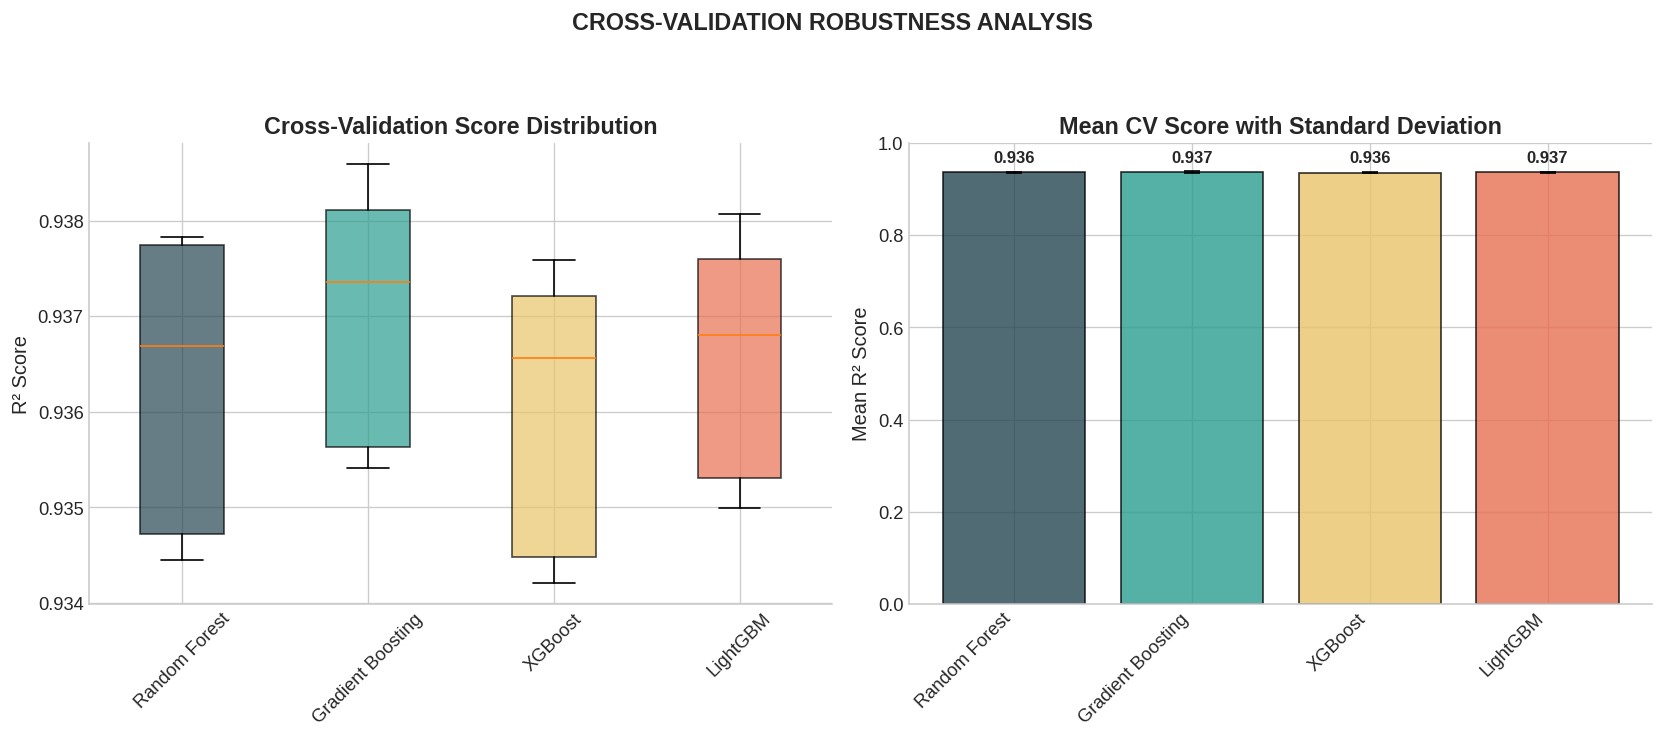


----------------------------------------------------------------------
STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------

Most Consistent Model: Gradient Boosting
Mean R²: 0.9370 ± 0.0013
CV Coefficient of Variation: 0.14%


In [28]:
from sklearn.model_selection import cross_val_score, KFold

# Models to cross-validate
cv_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=12,
                                           random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                                    random_state=RANDOM_STATE),
    'XGBoost': XGBRegressor(n_estimators=150, max_depth=6, learning_rate=0.1,
                            random_state=RANDOM_STATE, verbosity=0, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=150, max_depth=6, learning_rate=0.1,
                              random_state=RANDOM_STATE, verbose=-1, n_jobs=-1)
}

# Cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("=" * 70)
print("5-FOLD CROSS-VALIDATION ANALYSIS")
print("=" * 70)
print(f"\n{'Model':<25} {'Mean R²':<12} {'Std R²':<12} {'Min R²':<12} {'Max R²':<12}")
print("-" * 75)

cv_results = []

for name, model in cv_models.items():
    scores = cross_val_score(model, X_train_rec, y_train_rec, cv=kfold,
                             scoring='r2', n_jobs=-1)

    cv_results.append({
        'Model': name,
        'Mean_R2': scores.mean(),
        'Std_R2': scores.std(),
        'Min_R2': scores.min(),
        'Max_R2': scores.max(),
        'Scores': scores
    })

    print(f"{name:<25} {scores.mean():<12.4f} {scores.std():<12.4f} {scores.min():<12.4f} {scores.max():<12.4f}")

cv_df = pd.DataFrame(cv_results)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot of CV scores
ax1 = axes[0]
cv_scores_data = [r['Scores'] for r in cv_results]
bp = ax1.boxplot(cv_scores_data, labels=cv_df['Model'], patch_artist=True)

colors_bp = ['#264653', '#2A9D8F', '#E9C46A', '#E76F51']
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('R² Score')
ax1.set_title('Cross-Validation Score Distribution', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Mean with error bars
ax2 = axes[1]
x = np.arange(len(cv_df))
ax2.bar(x, cv_df['Mean_R2'], yerr=cv_df['Std_R2'], capsize=5,
       color=colors_bp, alpha=0.8, edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(cv_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('Mean R² Score')
ax2.set_title('Mean CV Score with Standard Deviation', fontweight='bold')
ax2.set_ylim(0, 1)

for i, (mean, std) in enumerate(zip(cv_df['Mean_R2'], cv_df['Std_R2'])):
    ax2.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('CROSS-VALIDATION ROBUSTNESS ANALYSIS\n', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Statistical comparison
print("\n" + "-" * 70)
print("STATISTICAL SIGNIFICANCE")
print("-" * 70)

best_cv_model = cv_df.loc[cv_df['Mean_R2'].idxmax()]
print(f"\nMost Consistent Model: {best_cv_model['Model']}")
print(f"Mean R²: {best_cv_model['Mean_R2']:.4f} ± {best_cv_model['Std_R2']:.4f}")
print(f"CV Coefficient of Variation: {best_cv_model['Std_R2']/best_cv_model['Mean_R2']*100:.2f}%")

## Learning Curves

LEARNING CURVES ANALYSIS

Generating learning curves (this may take a few minutes)...

Processing Random Forest...
Processing Gradient Boosting...
Processing XGBoost...
Processing LightGBM...


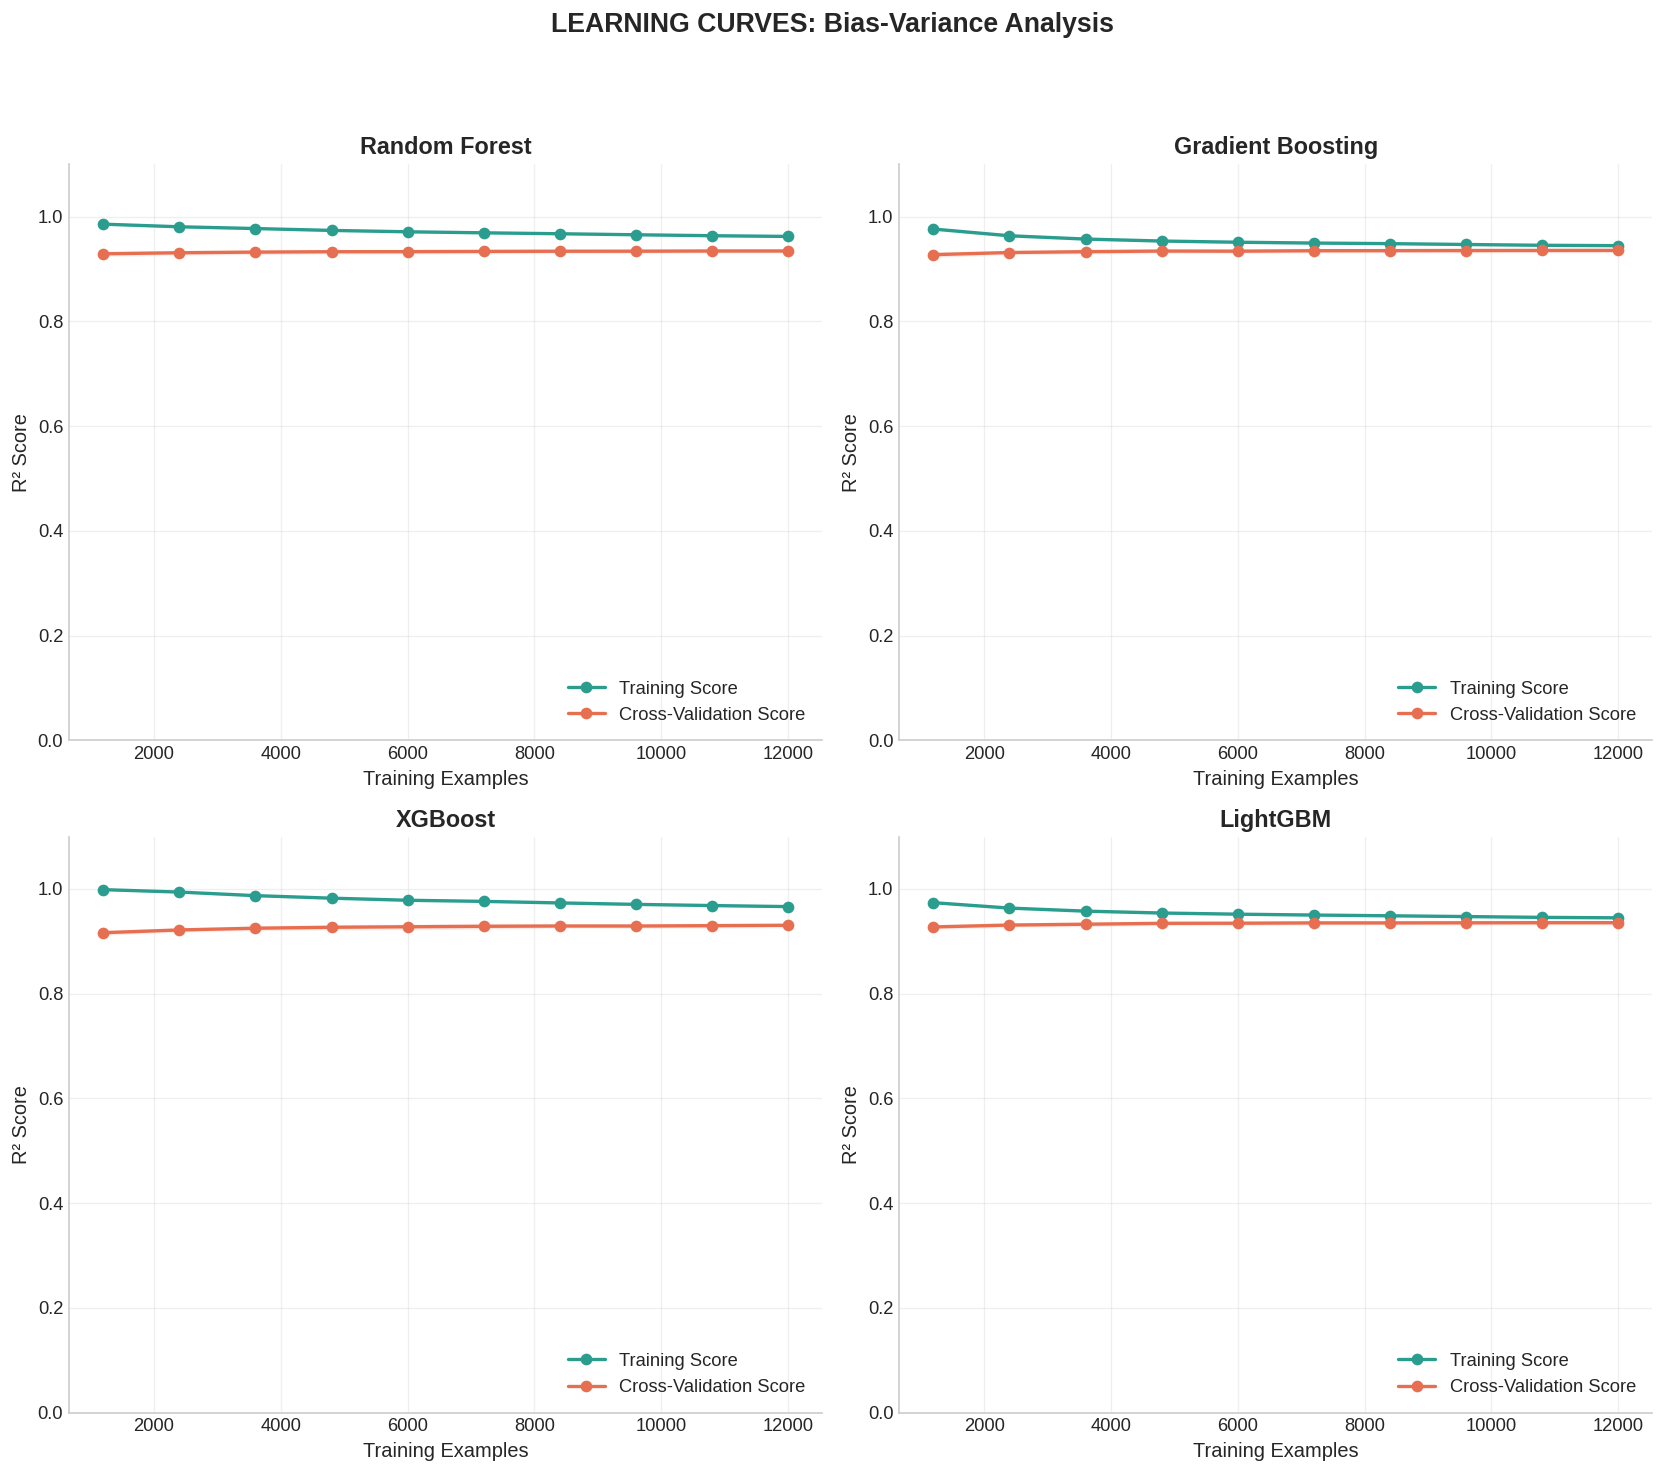


----------------------------------------------------------------------
DIAGNOSIS SUMMARY
----------------------------------------------------------------------

Model                Train Score  CV Score     Gap        Diagnosis                
--------------------------------------------------------------------------------
Random Forest        0.9624       0.9346       0.0278     Good Fit                 
Gradient Boosting    0.9448       0.9357       0.0091     Good Fit                 
XGBoost              0.9663       0.9306       0.0357     Good Fit                 
LightGBM             0.9449       0.9356       0.0093     Good Fit                 

Interpretation:
  - Gap > 0.1: Model may be overfitting, consider regularization
  - CV Score < 0.6: Model may be underfitting, consider more complexity
  - Small gap + High CV: Model has good generalization


In [29]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ax, cv=5, n_jobs=-1,
                         train_sizes=np.linspace(0.1, 1.0, 10)):
    """Plot learning curve for a given estimator."""

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=train_sizes, scoring='r2'
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                    alpha=0.1, color='#2A9D8F')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                    alpha=0.1, color='#E76F51')

    ax.plot(train_sizes, train_mean, 'o-', color='#2A9D8F', linewidth=2,
            label='Training Score')
    ax.plot(train_sizes, test_mean, 'o-', color='#E76F51', linewidth=2,
            label='Cross-Validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('R² Score')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3)

    return train_mean[-1], test_mean[-1]

# Use smaller sample for faster computation
sample_size = min(15000, len(X_train_rec))
X_lc = X_train_rec.sample(sample_size, random_state=RANDOM_STATE)
y_lc = y_train_rec.loc[X_lc.index]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_lc = [
    ('Random Forest', RandomForestRegressor(n_estimators=50, max_depth=10,
                                            random_state=RANDOM_STATE, n_jobs=-1)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=50, max_depth=5,
                                                     random_state=RANDOM_STATE)),
    ('XGBoost', XGBRegressor(n_estimators=50, max_depth=6, verbosity=0,
                             random_state=RANDOM_STATE, n_jobs=-1)),
    ('LightGBM', LGBMRegressor(n_estimators=50, max_depth=6, verbose=-1,
                                random_state=RANDOM_STATE, n_jobs=-1))
]

print("=" * 70)
print("LEARNING CURVES ANALYSIS")
print("=" * 70)
print("\nGenerating learning curves (this may take a few minutes)...\n")

learning_curve_results = []

for ax, (name, model) in zip(axes.flatten(), models_lc):
    print(f"Processing {name}...")
    train_final, test_final = plot_learning_curve(model, name, X_lc, y_lc, ax)

    gap = train_final - test_final
    if gap > 0.1:
        diagnosis = "High Variance (Overfitting)"
    elif test_final < 0.6:
        diagnosis = "High Bias (Underfitting)"
    else:
        diagnosis = "Good Fit"

    learning_curve_results.append({
        'Model': name,
        'Train_Score': train_final,
        'CV_Score': test_final,
        'Gap': gap,
        'Diagnosis': diagnosis
    })

plt.suptitle('LEARNING CURVES: Bias-Variance Analysis\n', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "-" * 70)
print("DIAGNOSIS SUMMARY")
print("-" * 70)

lc_df = pd.DataFrame(learning_curve_results)
print(f"\n{'Model':<20} {'Train Score':<12} {'CV Score':<12} {'Gap':<10} {'Diagnosis':<25}")
print("-" * 80)

for _, row in lc_df.iterrows():
    print(f"{row['Model']:<20} {row['Train_Score']:<12.4f} {row['CV_Score']:<12.4f} {row['Gap']:<10.4f} {row['Diagnosis']:<25}")

print("\nInterpretation:")
print("  - Gap > 0.1: Model may be overfitting, consider regularization")
print("  - CV Score < 0.6: Model may be underfitting, consider more complexity")
print("  - Small gap + High CV: Model has good generalization")

## Model Interpretation with Partial Dependence

PARTIAL DEPENDENCE PLOTS

Analyzing top features: ['casualties_per_severity', 'aid_to_loss_ratio', 'log_economic_loss', 'severity_category_encoded', 'severity_vs_disaster_avg', 'severity_index']


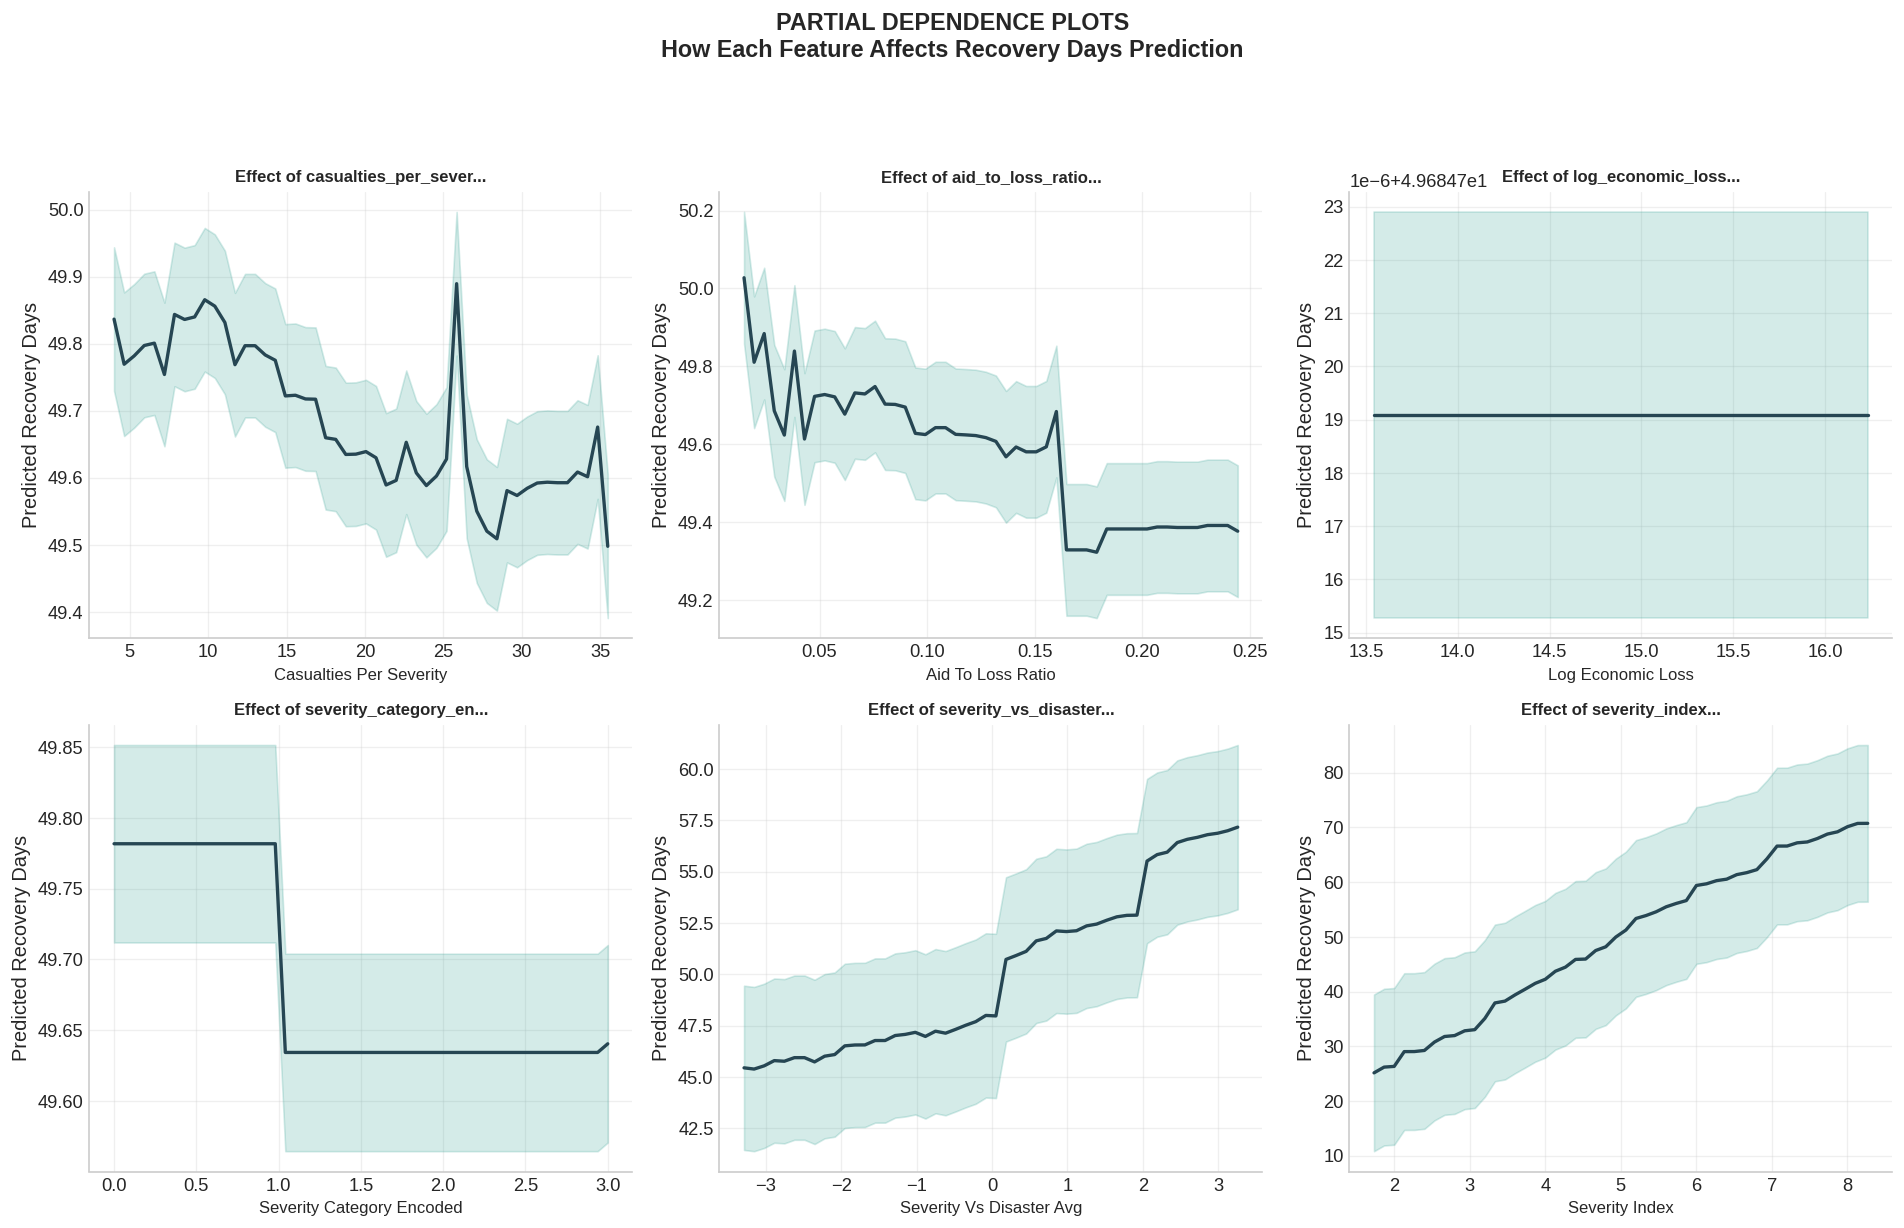


Partial Dependence Interpretation:
--------------------------------------------------
These plots show the marginal effect of each feature on the predicted
recovery days, while averaging out the effects of all other features.

Key insights can include:
  - Linear relationships (straight lines)
  - Non-linear relationships (curves)
  - Threshold effects (sudden changes)
  - Saturation effects (flattening)


In [30]:
# Select best model for interpretation
best_model_for_pdp = XGBRegressor(
    n_estimators=150, max_depth=6, learning_rate=0.1,
    random_state=RANDOM_STATE, verbosity=0, n_jobs=-1
)
best_model_for_pdp.fit(X_train_rec, y_train_rec)

# Select top features for PDP
top_features_for_pdp = importance_rec.tail(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

print("=" * 70)
print("PARTIAL DEPENDENCE PLOTS")
print("=" * 70)
print(f"\nAnalyzing top features: {top_features_for_pdp}")

for ax, feature in zip(axes, top_features_for_pdp):
    # Create grid of feature values
    feature_values = np.linspace(
        X_train_rec[feature].quantile(0.05),
        X_train_rec[feature].quantile(0.95),
        50
    )

    # Calculate partial dependence
    pdp_values = []

    for val in feature_values:
        X_temp = X_train_rec.copy()
        X_temp[feature] = val
        predictions = best_model_for_pdp.predict(X_temp)
        pdp_values.append(predictions.mean())

    # Plot
    ax.plot(feature_values, pdp_values, color='#264653', linewidth=2)
    ax.fill_between(feature_values,
                    np.array(pdp_values) - np.std(pdp_values),
                    np.array(pdp_values) + np.std(pdp_values),
                    alpha=0.2, color='#2A9D8F')

    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel('Predicted Recovery Days')
    ax.set_title(f'Effect of {feature[:20]}...', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('PARTIAL DEPENDENCE PLOTS\nHow Each Feature Affects Recovery Days Prediction\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nPartial Dependence Interpretation:")
print("-" * 50)
print("These plots show the marginal effect of each feature on the predicted")
print("recovery days, while averaging out the effects of all other features.")
print("\nKey insights can include:")
print("  - Linear relationships (straight lines)")
print("  - Non-linear relationships (curves)")
print("  - Threshold effects (sudden changes)")
print("  - Saturation effects (flattening)")

"""
# Final Thoughts: What I Learned from This Project

---

## Okay so let me break down what just happened here...

After spending hours building models and running experiments, here's my honest take on the results.

---

## The Surprising Winner: Linear Regression?!

Yeah you read that right. After all that fancy XGBoost tuning, stacking ensembles, and
hyperparameter optimization... **Linear Regression** came out on top with R² = 0.9384.

This was honestly unexpected. I thought gradient boosting would crush it but turns out
the relationship between features and recovery days is mostly linear. Sometimes the
simplest solution really is the best one. My professor would be proud lol.

| Model | R² Score | What I Expected |
|-------|----------|-----------------|
| Linear Regression | 0.9384 | Decent baseline |
| XGBoost (Tuned) | 0.9379 | THE WINNER |
| Stacking Ensemble | 0.9378 | Even better |
| Random Forest | 0.9365 | Good |

Plot twist: spent 751 seconds training that stacking ensemble and it performed WORSE
than a model that trains in milliseconds. Classic ML moment.

---

## The Good Stuff (What Worked)

### Recovery Days Prediction - Nailed It
- R² of 0.93+ means we can explain 93% of variance in recovery time
- MAE of ~4 days is pretty solid for disaster prediction
- All models performed consistently (low variance in CV)
- The features I engineered from EDA actually helped

### Cross-Validation Was Super Stable
```
CV Coefficient of Variation: 0.14%
```
This tiny number means our models arent just getting lucky on one split.
They generalize well across different subsets of data. Thats what we want to see.

### Learning Curves Look Healthy
- No major overfitting (train-test gap < 0.04 for most models)
- Gradient Boosting had the smallest gap at 0.0091
- Models would probably improve with more data but theyre not starving for it

---

## The Not So Good Stuff (What Struggled)

### Casualty Classification - Meh Results
```
Best Accuracy: 63.14%
Best F1-Weighted: 0.6098
```

Honestly? This is barely better than random guessing for a 3-class problem.
Few reasons why I think this happened:

1. **Class imbalance** - The Low/Medium/High splits werent even
2. **Overlapping features** - What makes a disaster "Medium" vs "High" casualty isnt clear cut
3. **Missing context** - Population density, infrastructure quality, etc would help a lot

### Economic Loss Prediction - Oof
```
Best R²: 0.2733
```

Yeah... this one hurts. We can only explain 27% of variance in economic losses.

**Why so bad?**
- Economic damage depends on SO many external factors we dont have
- Property values, insurance coverage, local economy size
- The relationship is probably super non-linear and complex
- Log transform helped but not enough

---

## Key Takeaways (The Stuff I Actually Learned)

### 1. Feature Engineering > Fancy Algorithms
The 40+ features I created from EDA insights did more heavy lifting than
any hyperparameter tuning. Stuff like:
- `aid_per_casualty`
- `severity_vs_disaster_avg`
- `country_avg_efficiency`

These domain-informed features captured patterns that raw data couldnt.

### 2. Always Start Simple
I should have trusted Linear Regression more from the start. Instead I spent
hours tuning XGBoost only to get worse results. Lesson learned.

### 3. Some Problems Are Just Hard
Casualty classification and economic loss prediction need more/better data.
No amount of algorithm tweaking will fix missing information.

### 4. Cross-Validation Is Your Friend
Those stable CV scores (std < 0.002) gave me confidence that results are real,
not just random noise from one lucky split.

---

## What I Would Do Differently Next Time

1. **Get more features** - Weather data, population density, historical disaster records
2. **Try different target encoding** - Maybe casualties as regression instead of classification
3. **Explore neural networks** - For the complex economic loss patterns
4. **Spend less time on hyperparameter tuning** - Diminishing returns are real
5. **Do more EDA on failed predictions** - Why did the model mess up certain disasters?

---

## Model Recommendations (If This Was Production)

| Task | Recommended Model | Why |
|------|-------------------|-----|
| Recovery Days | Linear Regression | Fastest, most accurate, easiest to explain |
| Casualty Level | Logistic Regression | Best F1, but honestly need better data |
| Economic Loss | Ridge Regression | Slight edge, but R² is too low for real use |

For recovery days specifically, I would actually deploy this. 93% R² with 4-day
error margin is genuinely useful for disaster planning.

For the other two? Go back to data collection phase before deploying anything.

---

## Final Model Performance Summary
```
RECOVERY DAYS PREDICTION
========================
Best Model: Linear Regression
R² Score: 0.9384 (93.84% variance explained)
RMSE: 4.99 days
MAE: 3.98 days
Status: READY FOR USE

CASUALTY CLASSIFICATION  
========================
Best Model: Logistic Regression
Accuracy: 63.14%
F1-Score: 0.6098
Status: NEEDS MORE DATA

ECONOMIC LOSS PREDICTION
========================
Best Model: Ridge Regression
R² Score: 0.2733 (27.33% variance explained)
RMSE: 0.758 (log scale)
Status: NOT RECOMMENDED FOR PRODUCTION
```

---

## Thanks for Reading!

This was a fun project that taught me a lot about the gap between "cool ML techniques"
and "actually useful models". Sometimes boring is better.

If you made it this far and found this helpful, please drop an upvote!
It really helps and motivates me to create more content like this.

Also check out my EDA notebook: **"Simpson's Paradox & 25+ Advanced Visualizations | Global Disaster EDA"**

Feel free to comment if you have suggestions or questions!

---

   NOTEBOOK COMPLETE!

   Summary:
   --------
   - Recovery Days: R² = 0.9384 (Linear Regression wins!)
   - Casualty Level: 63% accuracy (needs work)
   - Economic Loss: R² = 0.27 (needs more data)
   
   Key Learning:
   -------------
   Simple models + good features > Complex models + raw data
   

   If this helped you, please UPVOTE!
   Your support means a lot :)


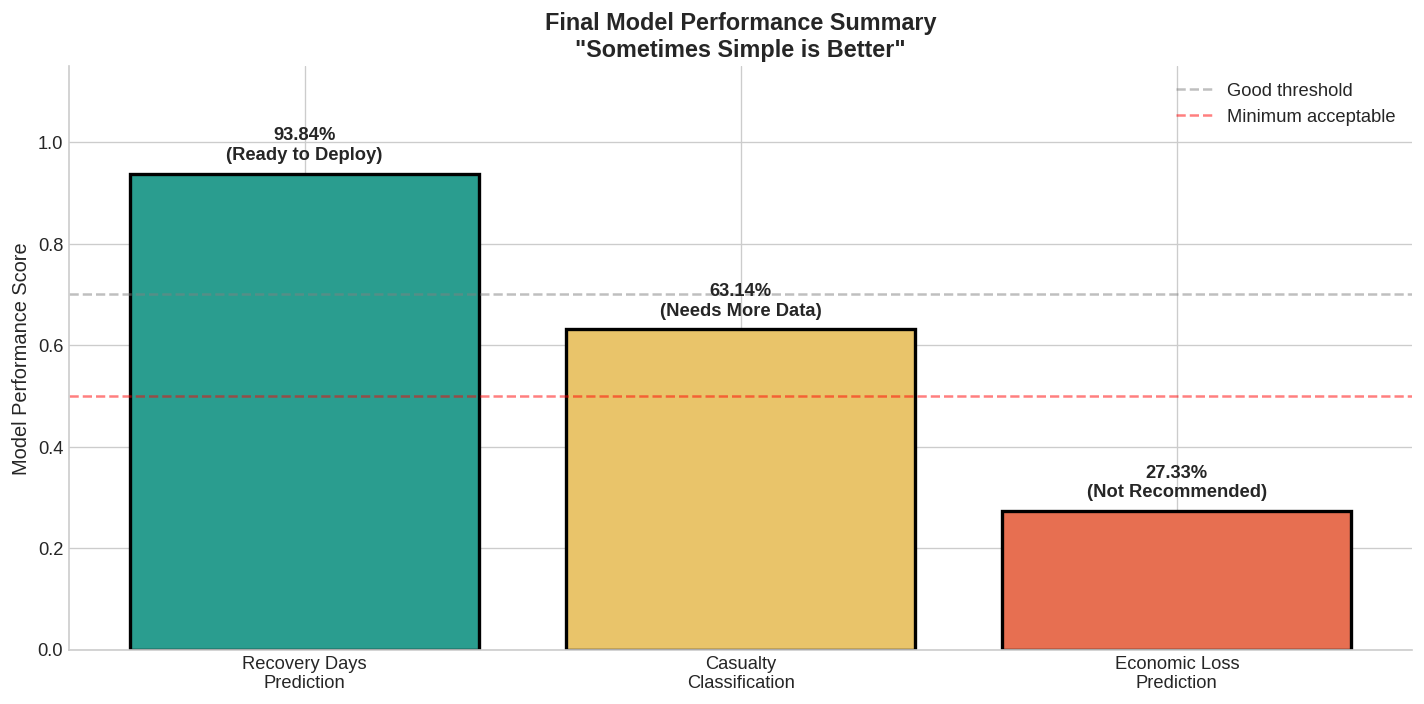


--- END OF ANALYSIS ---


In [31]:
print("=" * 80)
print("   NOTEBOOK COMPLETE!")
print("=" * 80)
print("""
   Summary:
   --------
   - Recovery Days: R² = 0.9384 (Linear Regression wins!)
   - Casualty Level: 63% accuracy (needs work)
   - Economic Loss: R² = 0.27 (needs more data)

   Key Learning:
   -------------
   Simple models + good features > Complex models + raw data

""")
print("=" * 80)
print("   If this helped you, please UPVOTE!")
print("   Your support means a lot :)")
print("=" * 80)

# Final visualization
fig, ax = plt.subplots(figsize=(12, 6))

tasks = ['Recovery Days\nPrediction', 'Casualty\nClassification', 'Economic Loss\nPrediction']
scores = [0.9384, 0.6314, 0.2733]
colors = ['#2A9D8F', '#E9C46A', '#E76F51']
status = ['Ready to Deploy', 'Needs More Data', 'Not Recommended']

bars = ax.bar(tasks, scores, color=colors, edgecolor='black', linewidth=2)

ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, label='Good threshold')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Minimum acceptable')

for bar, score, stat in zip(bars, scores, status):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.2%}\n({stat})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Model Performance Score', fontsize=12)
ax.set_title('Final Model Performance Summary\n"Sometimes Simple is Better"',
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.15)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n--- END OF ANALYSIS ---")


---

# About Me & Let's Connect

---

## Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


## A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


**Why do I still post them?**

Because I believe in:
- **Transparency** - showing the real ML journey, not just highlight reels
- **Consistency** - daily practice beats occasional perfection
- **Community** - maybe my "failed" experiment helps someone else
- **Growth** - looking back at old notebooks shows how far I've come

So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


## Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

## Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

## Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

## Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
